Now, what we want to do is choose between the Informer and LSTM.
Next, we will work on the experiment of reactive vs proactive.
  - First we need to set a threshold for our target variable as per SLA. (lets say 200)
  - Next we can start the comparison.
    - We use the same test bed.
    - We chose a pipeline trigger time of 3 min. This is a chosen parameter, but what we want is to avoid a ping pong scenario of migrating applications.
    - **Reactive:** Every 3 min the pipeline starts, checks if the last value is above the SLA.
        - If above, migrate.
        - If not, keep.
    - **Proactive:** Every 3 min the pipeline starts, predicts the next 3 min, checks if any predicted value is above the SLA.
        - If above, migrate.
        - If not, keep.
          
  - From the model perspective, we should try both options. 
    - To consider the CI of the errors to give more accurate predictions.
      - This will make the choice much more restrictive, as few predictions - CI will be under threshold. But also much safer, reducing unnecessary migration.
    - To use only model prediction. This will output much more migration but might be unnecessary.


We will do the comparison of approaches from multiple perspectives to see which one is better:
  - **Migrations perspective**: we will check the number of migrations that are triggered in each approach toghether with the quality of those migrations.
  - **Amount of time above SLA**: we will check the total amount of time above SLA for both approaches.
  - **Quantitative values of SLA vs PredictionTime**: we will check the descriptive statistics of the PredictionTime agains SLA. For each approach:
    - Migrations predicted correctly: statistics about the values above SLA that we avoided.
    - Migrations missed: statistics about the values above SLA that we have not been able to avoid.
    - Migrations predicted which were not needed: in this case, the values are expected to be under SLA, there would just be an empty migration cost which is mentioned but not calculated.
    

Do a Confussion matrix. It will be much clearer. 
  - True positive: we predicted migration and it was migration.
  - False positive: we predicted migration and it was not needed.
  - True negative: we didn't predict migration and it was not needed.
  - False negative: we didn't predict migration and it was needed.

In [1]:
import numpy as np
import pandas as pd

# Define SLA threshold and trigger time
SLA_THRESHOLD = 0.200
TRIGGER_TIME_steps = 10

def reactive_approach(input, true, mean):
    """
    Reactive approach:
    Every TRIGGER_TIME_steps minutes, check if the last value of 'input' (current values) is above SLA.
    If above, simulate migration.
    Calculate:
    - prior_incidents: Amount of time above SLA in the last 5 minutes.
    - migration: whether the reactive migration is triggered.
    - unnecessary_migration: based on the 'true' values (whether the next TRIGGER_TIME_steps minutes are above SLA or not).
    - future_incidents: amount of time above SLA in the next TRIGGER_TIME_steps min.
    """
    last_TRIGGER_TIME_steps = input[-TRIGGER_TIME_steps:]  # Get the last TRIGGER_TIME_steps minutes from input
    prior_incidents = np.sum(last_TRIGGER_TIME_steps > SLA_THRESHOLD)  # Count SLA incidents in the past 3 minutes
    reactive_migration = False
    
    # Calculate average of last TRIGGER_TIME_steps minutes and check if above SLA
    # if np.mean(last_TRIGGER_TIME_steps) > SLA_THRESHOLD:
    #     reactive_migration = True
    if mean==False:
        # Trigger migration if the last value is above the SLA
        if np.any(last_TRIGGER_TIME_steps[-1] > SLA_THRESHOLD):
            reactive_migration = True
    else:
        # Trigger migration if the mean of the last values is above the SLA
        if np.mean(last_TRIGGER_TIME_steps) > SLA_THRESHOLD:
            reactive_migration = True
    
    # Check if the next last_TRIGGER_TIME_steps min (true) would have been above SLA (unnecessary migration check)
    future_incidents = np.sum(true > SLA_THRESHOLD)
    
    # If migration occurred but next last_TRIGGER_TIME_steps min were below SLA, it's unnecessary
    unnecessary_migration = reactive_migration and (future_incidents == 0)
    
    return {
        'prior_incidents': prior_incidents,
        'migration': reactive_migration,
        'unnecessary_migration': unnecessary_migration,
        'future_incidents': future_incidents
    }

def proactive_approach(input, pred, true, mean):
    """
    Proactive approach:
    Every TRIGGER_TIME_steps minutes, predict the next TRIGGER_TIME_steps minutes. Migrate if any predicted values are above SLA.
    Calculate:
    - migration: whether we migrate or not based on prediction.
    - unnecessary_migration: whether migration was needed or not based on 'true' values.
    - future_incidents: amount of time above SLA in the next TRIGGER_TIME_steps min.
    """
    if mean:
        # If mean is True, we use the mean of the predicted values
        proactive_migration = np.mean(pred) > SLA_THRESHOLD
    else:
        # If mean is False, we check if any of the predicted values are above SLA
        proactive_migration = np.any(pred > SLA_THRESHOLD)
    
    # Calculate the amount of time that would have been above SLA (input + true)
    prior_incidents = np.sum(input[-TRIGGER_TIME_steps:] > SLA_THRESHOLD)  # Last TRIGGER_TIME_steps minutes incidents
    
    # If migration was triggered but next TRIGGER_TIME_steps min were below SLA, it's unnecessary
    future_incidents = np.sum(true > SLA_THRESHOLD)
    unnecessary_migration = proactive_migration and (future_incidents == 0)
    
    return {
        'prior_incidents': prior_incidents,
        'migration': proactive_migration,
        'unnecessary_migration': unnecessary_migration,
        'future_incidents': future_incidents
    }

def run_experiment(input_data, pred_data, true_data, mean=False):
    """
    Run the experiment by comparing reactive and proactive approaches over the dataset.
    input_data: Array of past target values (shape: [n_samples, 10])
    pred_data: Predicted next TRIGGER_TIME_steps timesteps (shape: [n_samples, 10])
    true_data: Actual true next TRIGGER_TIME_steps timesteps (shape: [n_samples, 10])
    """
    n_samples = input_data.shape[0]
    reactive_results = []
    proactive_results = []
    
    for i in range(n_samples):
        # Get input, predicted, and true values for the current sample
        input_sample = input_data[i]
        pred_sample = pred_data[i]
        true_sample = true_data[i]
        
        # Run reactive approach
        reactive_result = reactive_approach(input_sample, true_sample, mean)
        reactive_results.append(reactive_result)
        
        # Run proactive approach
        proactive_result = proactive_approach(input_sample, pred_sample, true_sample, mean)
        proactive_results.append(proactive_result)
    
    # Convert results to a more accessible format
    reactive_df = pd.DataFrame(reactive_results)
    proactive_df = pd.DataFrame(proactive_results)
    
    return reactive_df, proactive_df

def calculate_confusion_matrix_metrics(df):
    """
    Calculate confusion matrix (TP, FP, TN, FN) and derived metrics: Accuracy, Precision, Recall, F1-Score, Specificity.
    """
    # True Positive (TP): Predicted migration and it was needed
    TP = np.sum((df['migration'] == True) & (df['future_incidents'] > 0))
    
    # False Positive (FP): Predicted migration but it was not needed
    FP = np.sum((df['migration'] == True) & (df['future_incidents'] == 0))
    
    # True Negative (TN): Predicted no migration and it was not needed
    TN = np.sum((df['migration'] == False) & (df['future_incidents'] == 0))
    
    # False Negative (FN): Predicted no migration but it was needed
    FN = np.sum((df['migration'] == False) & (df['future_incidents'] > 0))
    
    total = TP + FP + TN + FN
    
    # Derived metrics in percentage
    accuracy = (TP + TN) / total * 100 if total > 0 else 0
    precision = TP / (TP + FP) * 100 if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return TP, FP, TN, FN, accuracy, precision, recall, f1_score, specificity

def summary_statistics_with_confusion_matrix(df, approach_name="Approach"):
    """
    Calculate confusion matrix details and metrics for a single approach (reactive, proactive, proactive_ci).
    """
    # Calculate confusion matrix and derived metrics
    TP, FP, TN, FN, acc, prec, recall, f1, spec = calculate_confusion_matrix_metrics(df)
    
    # Print confusion matrix and metrics in tabular format
    print(f"\n{approach_name} Confusion Matrix:")
    print(f"                  Predicted Migration   Predicted No Migration")
    print(f"Actual Migration       TP: {TP}                FN: {FN}")
    print(f"Actual No Migration    FP: {FP}                TN: {TN}")
    
    # Print metrics for the approach
    print(f"\n{approach_name} Metrics (in %):")
    print(f"  Accuracy: {acc:.2f}%")
    print(f"  Precision: {prec:.2f}%")
    print(f"  Recall: {recall:.2f}%")
    print(f"  F1 Score: {f1:.2f}%")
    print(f"  Specificity: {spec:.2f}%")




In [2]:
import numpy as np
import pandas as pd

# Define SLA threshold
SLA_THRESHOLD = 0.200

def reactive_approach_minute_by_minute(input_series, true_series):
    """
    Reactive approach that evaluates every minute.
    
    Parameters:
    input_series: Array of past values (last 10-20 timesteps)
    true_series: Array of future values (next 3 minutes)
    
    Returns:
    Dictionary containing:
    - migration: Array of booleans indicating if migration was triggered at each minute
    - unnecessary_migration: Array of booleans indicating if each migration was needed
    """
    n_minutes = len(true_series)  # This will be 3
    migration = []
    future_incidents=[]
    
    # Get the most recent value from input_series
    latest_value = input_series[-1]
    
    # Make decisions for each minute
    for minute in range(n_minutes):
        # Decide whether to migrate based on latest value
        should_migrate = latest_value > SLA_THRESHOLD        
        migration.append(should_migrate)
        # Update latest value for next iteration
        latest_value = true_series[minute]
        if true_series[minute] > SLA_THRESHOLD:
            future_incidents.append(True)
        else:
            future_incidents.append(False)

    
    # Convert lists to numpy arrays for consistency
    migration = np.array(migration)
    future_incidents=np.array(future_incidents)

    return {
        'migration': migration,  # Array of [bool, bool, bool] for migration decisions
        'future_incidents': future_incidents  # Array of [bool, bool, bool] for actual violations
    }


def proactive_approach_with_window(pred_series, true_series):
    """
    Proactive approach that makes decisions every 3 minutes.
    
    Parameters:
    input_series: Array of past values
    pred_series: Array of predicted values (for next 3 minutes)
    true_series: Array of actual values (for next 3 minutes)
    
    Returns:
    Dictionary containing metrics for this time window
    """
    # Make decision based on predictions
    should_migrate = np.any(pred_series > SLA_THRESHOLD)
    
    # If migration was triggered but next 3 min were below SLA, it's unnecessary
    future_incidents = np.sum(true_series > SLA_THRESHOLD)

    return {
        'migration': should_migrate,
        'future_incidents': future_incidents
    }

def run_minute_by_minute_experiment(input_data, pred_data, true_data):
    """
    Run the experiment comparing approaches with minute-by-minute tracking.
    
    Parameters:
    input_data: Array of shape [n_samples, window_size]
    pred_data: Array of shape [n_samples, prediction_horizon]
    true_data: Array of shape [n_samples, prediction_horizon]
    """
    n_samples = len(input_data)
    reactive_results = []
    proactive_results = []
    
    for i in range(n_samples):
        # Get current window of data
        input_window = input_data[i]
        pred_window = pred_data[i]
        true_window = true_data[i]
        
        # Run both approaches
        reactive_result = reactive_approach_minute_by_minute(input_window, true_window)
        proactive_result = proactive_approach_with_window(pred_window, true_window)
        
        reactive_results.append(reactive_result)
        proactive_results.append(proactive_result)
    
    return pd.DataFrame(reactive_results), pd.DataFrame(proactive_results)

def calculate_confusion_matrix_metrics_reactive(results_df):
    """
    Calculate confusion matrix metrics from arrays of migration decisions and actual incidents.
    
    For each minute:
    - TP: migration=True and future_incidents=True (we migrated and it was needed)
    - FP: migration=True and future_incidents=False (we migrated but it wasn't needed)
    - TN: migration=False and future_incidents=False (we didn't migrate and no need)
    - FN: migration=False and future_incidents=True (we didn't migrate but should have)
    """
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    # Iterate through each sample's results
    for i in range(len(results_df)):
        migration = results_df['migration'].iloc[i]
        incidents = results_df['future_incidents'].iloc[i]
        
        # For each minute in the window
        for m, f in zip(migration, incidents):
            if m:  # If we decided to migrate
                if f:  # If there was an incident (it was needed)
                    TP += 1
                else:  # If there was no incident (it wasn't needed)
                    FP += 1
            else:  # If we decided not to migrate
                if f:  # If there was an incident (we should have migrated)
                    FN += 1
                else:  # If there was no incident (correctly didn't migrate)
                    TN += 1
    
    # Calculate metrics
    total = TP + FP + TN + FN
    accuracy = (TP + TN) / total * 100 if total > 0 else 0
    precision = TP / (TP + FP) * 100 if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'specificity': specificity,
        'total':TP+FP+TN+FN
    }

def calculate_confusion_matrix_metrics_proactive(df):
    """
    Calculate confusion matrix (TP, FP, TN, FN) and derived metrics: Accuracy, Precision, Recall, F1-Score, Specificity.
    """
    # True Positive (TP): Predicted migration and it was needed
    TP = np.sum((df['migration'] == True) & (df['future_incidents'] > 0))
    
    # False Positive (FP): Predicted migration but it was not needed
    FP = np.sum((df['migration'] == True) & (df['future_incidents'] == 0))
    
    # True Negative (TN): Predicted no migration and it was not needed
    TN = np.sum((df['migration'] == False) & (df['future_incidents'] == 0))
    
    # False Negative (FN): Predicted no migration but it was needed
    FN = np.sum((df['migration'] == False) & (df['future_incidents'] > 0))
    
    total = TP + FP + TN + FN
    
    # Derived metrics in percentage
    accuracy = (TP + TN) / total * 100 if total > 0 else 0
    precision = TP / (TP + FP) * 100 if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'specificity': specificity,
        'total':TP+FP+TN+FN
    }
    
def summary_statistics_with_confusion_matrix_min_by_min(df, approach_name="Approach"):
    """
    Calculate and print confusion matrix details and metrics.
    """
    if approach_name=="Reactive Approach":
        metrics = calculate_confusion_matrix_metrics_reactive(df)
    elif approach_name=="Proactive Approach": 
        metrics = calculate_confusion_matrix_metrics_proactive(df)
    
    print(f"\n{approach_name} Confusion Matrix:")
    print(f"                  Predicted Migration   Predicted No Migration")
    print(f"Actual Migration       TP: {metrics['TP']}                FN: {metrics['FN']}")
    print(f"No Migration          FP: {metrics['FP']}                TN: {metrics['TN']}")
    
    print(f"\n{approach_name} Metrics (in %):")
    print(f"  Accuracy: {metrics['accuracy']:.2f}%")
    print(f"  Precision: {metrics['precision']:.2f}%")
    print(f"  Recall: {metrics['recall']:.2f}%")
    print(f"  F1 Score: {metrics['f1_score']:.2f}%")
    print(f"  Specificity: {metrics['specificity']:.2f}%")
    print(f"  Total: {metrics['total']:.2f}")

### Migrations perspective

- True Positive (TP): We predicted a migration, and migration was necessary (i.e., future SLA violations).
- False Positive (FP): We predicted a migration, and no migration was needed (i.e., no future SLA violations).
- True Negative (TN): We predicted no migration, and no migration was needed (i.e., no future SLA violations).
- False Negative (FN): We predicted no migration, but migration was necessary (i.e., future SLA violations).

- Accuracy: How often the model was correct. (TP+TN)/All
- Precision: Proportion of correctly predicted migrations among all predicted migrations. TP/(TP+FP)
- Recall: Proportion of actual migrations that were correctly predicted. TP/(TP+FN)
- F1 Score: The harmonic mean of Precision and Recall. (2·Precision·Recall)/(Precision+Recall)
- Specificity: Proportion of actual non-migrations that were correctly predicted. TN/(FP+TN)

For our usecase, the metrics that are most important are **first, Precision and second, Recall**:
 - **Precision**: shows the confidence on the predictions from our approach, meaning how many predictions are correct from the total amount of predictions. Performing a migration will always incur in a cost, as from an infrastructure perspective we would need to start the service in the other machine, switch the requests to the new service and shut down the past service. This is a fixed cost that will always happen in a migration, although the benefits of migrating when needed outweight this cost, for that reason is specially important to not trigger unneeded migrations, as they would incur in empty costs, harming the QoS of the application without adding any benefit to it. 
 
 Thus, it is important that when a migration is predicted, it was indeed needed.
 - **Recall**: shows the ability of our approach to differentiate when the application will need a migration or not. It is important as it measures how able is our approach to capture the actual migrations based on the given inputs, learning from the data and finding the patterns that parametrize the target variable. A better Recall means an approach that can better predict when we will be above SLA in the future steps. 

 Thus, to wrap up both metrics for comparison **F1 Score** can be used. A second order important metric to consider is **Specificity**, as it shows how our approach is able to discern when there is no need to have a migration, which again, it's interesting to ensure our model does not trigger unneeded migration costs. 

In [3]:
import os
current_dir = os.path.abspath('')
print(current_dir)
root = os.path.dirname(current_dir)
print(root)


/home/jolivera/Documents/CloudSkin/Time-Series-Library/result_analysis
/home/jolivera/Documents/CloudSkin/Time-Series-Library


In [5]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)
# setting = "informer_custom_ftMS_sl20_ll6_pl3_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0" 
setting="long_term_forecast_custom_Informer_custom_ftMS_sl10_ll5_pl10_dm256_nh8_el2_dl1_df512_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0"

preds = np.load(root+'/results/'+setting+'/pred.npy')
trues = np.load(root+'/results/'+setting+'/true.npy')
inputs = np.load(root+'/results/'+setting+'/input.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape, inputs.shape

FileNotFoundError: [Errno 2] No such file or directory: '/home/jolivera/Documents/CloudSkin/Time-Series-Library/results/long_term_forecast_custom_Informer_custom_ftMS_sl10_ll5_pl10_dm256_nh8_el2_dl1_df512_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/pred.npy'

In [5]:
inputs[0]

array([[ 0.        ,  1.        , -0.04060118, -0.91152155, -0.5133822 ,
        -1.0992486 , -0.444146  , -0.40466967,  0.5945449 , -0.43173724],
       [ 0.        ,  1.        , -0.04090605, -0.9130059 , -0.51390684,
        -1.0943263 , -0.40809613, -0.4090293 ,  0.5945449 , -0.80656594],
       [ 0.        ,  1.        , -0.04039193, -0.9151992 , -0.4961559 ,
        -1.0997767 , -0.41190866, -0.40620476,  0.5945449 , -0.88984925],
       [ 0.        ,  1.        , -0.0415013 , -0.917002  , -0.56910044,
        -1.0913651 , -0.43138602, -0.39972672,  0.5945449 , -0.7286478 ],
       [ 0.        ,  1.        , -0.04172849, -0.9163129 , -0.52157956,
        -1.0848119 , -0.46370706, -0.400832  ,  0.5945449 , -0.85143274],
       [ 0.        ,  1.        , -0.04114995, -0.9188965 , -0.5183223 ,
        -1.0909934 , -0.41801006, -0.40338022,  0.5945449 , -0.9541635 ],
       [ 0.        ,  1.        , -0.04217169, -0.91974103, -0.55168724,
        -1.0867279 , -0.43988898, -0.39423114

In [6]:
inputs[0][0]

array([ 0.        ,  1.        , -0.04060118, -0.91152155, -0.5133822 ,
       -1.0992486 , -0.444146  , -0.40466967,  0.5945449 , -0.43173724],
      dtype=float32)

In [7]:
import numpy as np

# inputs.shape == (29635, 10, 10)
# Axis 0 = samples, axis 1 = time steps, axis 2 = features

# Reshape to (29635 * 10, 10) to flatten time across all samples
flattened = inputs.reshape(-1, 10)  # shape: (296350, 10)

# Compute stats per feature (column-wise)
for i in range(flattened.shape[1]):
    feature_values = flattened[:, i]
    print(f"Feature {i:>2}: "
          f"Min = {feature_values.min():.4f}, "
          f"Max = {feature_values.max():.4f}, "
          f"Mean = {feature_values.mean():.4f}, "
          f"Std = {feature_values.std():.4f}")


Feature  0: Min = 0.0000, Max = 1.0000, Mean = 0.5002, Std = 0.5000
Feature  1: Min = 0.0000, Max = 1.0000, Mean = 0.4998, Std = 0.5000
Feature  2: Min = -0.0488, Max = 83.1103, Mean = 0.0104, Std = 0.8995
Feature  3: Min = -1.1482, Max = 5.1386, Mean = 0.0017, Std = 1.0109
Feature  4: Min = -2.1294, Max = 1.5791, Mean = -0.0350, Std = 1.0101
Feature  5: Min = -1.2304, Max = 1.1927, Mean = -0.0136, Std = 1.0038
Feature  6: Min = -2.1653, Max = 1.5858, Mean = -0.0332, Std = 1.0060
Feature  7: Min = -3.1897, Max = 2.0258, Mean = 0.1390, Std = 0.8680
Feature  8: Min = -2.4090, Max = 0.5945, Mean = -0.0325, Std = 1.0473
Feature  9: Min = -1.1397, Max = 7.8971, Mean = -0.0170, Std = 0.9993


In [54]:
import pandas as pd
df_1=pd.read_csv('/home/jolivera/Documents/CloudSkin/Time-Series-Library/dataset/partial_validation_dataset/preprocessed/inference_data_eb0e3eaa_b668_4ad6_bc10_2bb0eb7da259_20250805_161301.csv')
df_2=pd.read_csv('/home/jolivera/Documents/CloudSkin/Time-Series-Library/dataset/partial_validation_dataset/preprocessed/inference_data_fd7816db_7948_4602_af7a_1d51900792a7_20250805_161301.csv')
df=pd.concat([df_1,df_2], ignore_index=True).sort_values(by='date')


In [55]:
df.columns

Index(['date', 'cluster', 'pipelines_status_avg_fps',
       'pipelines_status_avg_pipeline_latency', 'node_cpu_usage',
       'node_mem_usage', 'pipelines_server_cpu_usage',
       'pipelines_server_mem_usage', 'number_pipelines',
       'pipelines_status_realtime_pipeline_latency'],
      dtype='object')

In [62]:
df.date.duplicated().any()

False

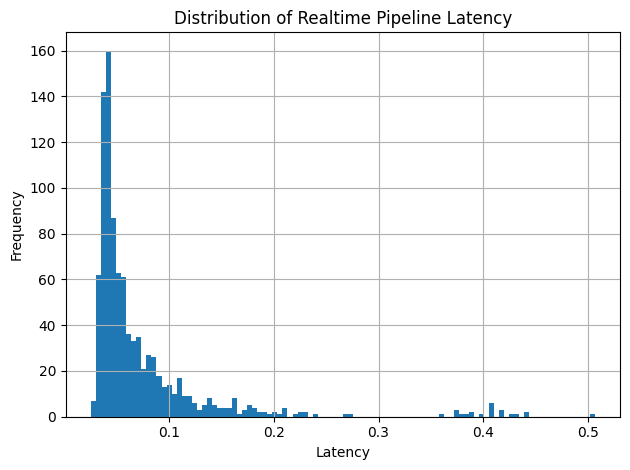

In [63]:
import matplotlib.pyplot as plt

# Plot histogram
df.pipelines_status_realtime_pipeline_latency.hist(bins=100)

# Add title and y-axis label
plt.title('Distribution of Realtime Pipeline Latency')
plt.ylabel('Frequency')
plt.xlabel('Latency')

# Show the plot
plt.tight_layout()
plt.show()


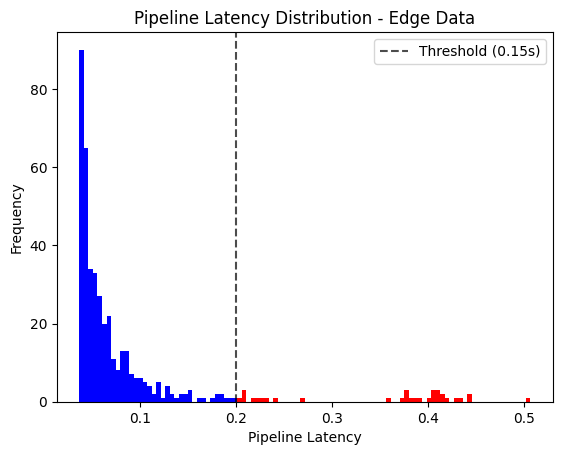

count    429.000000
mean       0.085657
std        0.086089
min        0.036827
25%        0.042761
50%        0.054980
75%        0.083565
max        0.506301
Name: pipelines_status_realtime_pipeline_latency, dtype: float64
0.2085311349232991


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram data
data = df[df['cluster']=='eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259'].pipelines_status_realtime_pipeline_latency.dropna()
counts, bins, patches = plt.hist(data, bins=100)

# Color bars based on bin centers
for i, (patch, bin_left, bin_right) in enumerate(zip(patches, bins[:-1], bins[1:])):
    bin_center = (bin_left + bin_right) / 2
    if bin_center >= 0.2:
        patch.set_facecolor('red')  # Color for values >= 0.15
    else:
        patch.set_facecolor('blue')  # Color for values < 0.15

plt.axvline(x=0.2, color='black', linestyle='--', alpha=0.7, label='Threshold (0.15s)')
plt.xlabel('Pipeline Latency')
plt.ylabel('Frequency')
plt.title('Pipeline Latency Distribution - Edge Data')
plt.legend()
plt.show()

print(data.describe())
print(data.quantile(0.93))

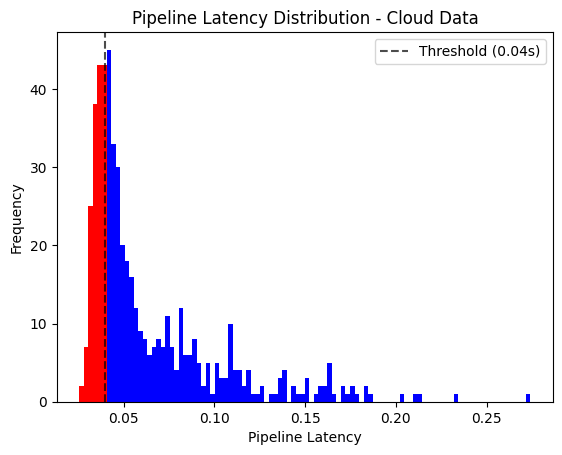

count    524.000000
mean       0.063924
std        0.037966
min        0.025679
25%        0.039128
50%        0.047352
75%        0.076365
max        0.274067
Name: pipelines_status_realtime_pipeline_latency, dtype: float64
0.04322638750076285


In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram data
data = df[df['cluster']=='fd7816db-7948-4602-af7a-1d51900792a7'].pipelines_status_realtime_pipeline_latency.dropna()
counts, bins, patches = plt.hist(data, bins=100)

# Color bars based on bin centers
for i, (patch, bin_left, bin_right) in enumerate(zip(patches, bins[:-1], bins[1:])):
    bin_center = (bin_left + bin_right) / 2
    if bin_center <= 0.04:
        patch.set_facecolor('red')  # Color for values >= 0.15
    else:
        patch.set_facecolor('blue')  # Color for values < 0.15

plt.axvline(x=0.04, color='black', linestyle='--', alpha=0.7, label='Threshold (0.04s)')
plt.xlabel('Pipeline Latency')
plt.ylabel('Frequency')
plt.title('Pipeline Latency Distribution - Cloud Data')
plt.legend()
plt.show()

print(data.describe())
print(data.quantile(0.39))

In [66]:
df_results=pd.read_csv('/home/jolivera/Documents/CloudSkin/Time-Series-Library/dataset/partial_validation_dataset/validation-reactive-8h-concurrency-4-job-0_2025-07-10T083023_2025-07-10T163025_created_at_2025-07-10T163027_mlflow_results_cloudedge-migration-experiment-ci.csv',sep=';')
df_results=df_results.drop(columns=["cluster_1","qos_1"])
df_results.head()

,start_time,end_time,duration,run_id,status,cluster_0,max_cluster,analysed,qos_0,max_qos,max_idx,mlflow.user,mlflow.source.name,mlflow.source.type,mlflow.runName
0,1752136514,1752136538,24,262904b7d17745f284de0f7cec6fa840,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.052828,0.052828,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
1,1752136810,1752136834,24,9709812edb784d2f970404d3de9f4ad1,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.053324,0.053324,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
2,1752137108,1752137131,22,d8e44825db6141298cfb2cc1ade332da,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.048312,0.048312,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
3,1752137413,1752137437,24,04f66f8742cf49629873cc49935cb7de,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.046710,0.046710,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
4,1752137708,1752137733,24,98c6873e95b34af786d098bad8737574,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.051033,0.051033,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer


In [67]:
print(min(df_results["start_time"]))
print(max(df_results["start_time"]))

1752136514
1752165010


First Timestamp from metrics:
1752136200
Last Timestamp from metrics:
1752165000

First Timestamp from MLFlow:
1752136514
Last Timestamp from MLFlow:
1752165010

In [86]:
import pandas as pd
from datetime import timedelta

def add_actual_metrics(df_results, df_metrics):
    """
    Add actual mean and max latency columns to results dataframe.
    
    Parameters:
    - df_results: Results dataframe with 5-minute predictions
    - df_metrics: Metrics dataframe with 30-second actual data
    
    Returns:
    - df_results with two new columns added
    """
    
    # Make a copy to avoid modifying the original
    df_results_copy = df_results.copy()
    
    # Ensure timestamps are datetime
    df_results_copy['start_time'] = pd.to_datetime(df_results_copy['start_time'],unit='s')
    df_results_copy['end_time'] = pd.to_datetime(df_results_copy['end_time'],unit='s')
    df_metrics_copy = df_metrics.copy()
    df_metrics_copy['date'] = pd.to_datetime(df_metrics_copy['date'])  # Adjust column name if needed
    
    # Initialize new columns
    df_results_copy['real_future_values_5_min_mean'] = None
    df_results_copy['real_future_values_5_min_max'] = None
    
    # For each row in results
    for idx, row in df_results_copy.iterrows():
        # Round down to the nearest minute (10:55:14 becomes 10:55:00)
        start_time = row['start_time'].replace(second=0, microsecond=0)
        end_time = start_time + timedelta(minutes=5)
        
        # Filter metrics data for this 5-minute window
        window_data = df_metrics_copy[
            (df_metrics_copy['date'] >= start_time) & 
            (df_metrics_copy['date'] < end_time)
        ]
        
        # Calculate mean and max if data exists
        if not window_data.empty:
            latency_values = window_data['pipelines_status_realtime_pipeline_latency'].dropna()
            
            if not latency_values.empty:
                df_results_copy.loc[idx, 'real_future_values_5_min_mean'] = latency_values.mean()
                df_results_copy.loc[idx, 'real_future_values_5_min_max'] = latency_values.max()
    
    return df_results_copy

# Usage:
df_results_enhanced = add_actual_metrics(df_results, df)

Vale, la funcio d'adalt el que fa es agafarme un arxiu de validation de mlflow i el compara amb un arxiu de raw data i m'afegeix les metriques mean and max latency. Imagino que això va bé per comparar després amb un plot els valors reals dels predit.

In [87]:
df_results_enhanced

,start_time,end_time,duration,run_id,status,cluster_0,max_cluster,analysed,qos_0,max_qos,max_idx,mlflow.user,mlflow.source.name,mlflow.source.type,mlflow.runName,real_future_values_5_min_mean,real_future_values_5_min_max
0,2025-07-10 08:35:14,2025-07-10 08:35:38,24,262904b7d17745f284de0f7cec6fa840,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.052828,0.052828,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.054551,0.077981
1,2025-07-10 08:40:10,2025-07-10 08:40:34,24,9709812edb784d2f970404d3de9f4ad1,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.053324,0.053324,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.048446,0.076385
2,2025-07-10 08:45:08,2025-07-10 08:45:31,22,d8e44825db6141298cfb2cc1ade332da,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.048312,0.048312,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.045068,0.058773
3,2025-07-10 08:50:13,2025-07-10 08:50:37,24,04f66f8742cf49629873cc49935cb7de,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.046710,0.046710,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.051698,0.066051
4,2025-07-10 08:55:08,2025-07-10 08:55:33,24,98c6873e95b34af786d098bad8737574,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.051033,0.051033,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.057277,0.0837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2025-07-10 16:10:12,2025-07-10 16:10:36,23,f5a38f7e67344a0b8ecd4fa99918b610,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.072349,0.072349,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.066097,0.158192
92,2025-07-10 16:15:08,2025-07-10 16:15:32,24,29baeae370ec4224841770d77b02ac37,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.067392,0.067392,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.058708,0.094797
93,2025-07-10 16:20:18,2025-07-10 16:20:39,21,00cd3177bfa34ed39be066b9585064a5,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.057535,0.057535,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.062029,0.166699
94,2025-07-10 16:25:12,2025-07-10 16:25:36,23,4852de966b34412bbce2bc88ac1bde71,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.061406,0.061406,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.079531,0.163444


In [96]:
df_results

,start_time,end_time,duration,run_id,status,cluster_0,max_cluster,analysed,qos_0,max_qos,max_idx,mlflow.user,mlflow.source.name,mlflow.source.type,mlflow.runName
0,1752136514,1752136538,24,262904b7d17745f284de0f7cec6fa840,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.052828,0.052828,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
1,1752136810,1752136834,24,9709812edb784d2f970404d3de9f4ad1,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.053324,0.053324,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
2,1752137108,1752137131,22,d8e44825db6141298cfb2cc1ade332da,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.048312,0.048312,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
3,1752137413,1752137437,24,04f66f8742cf49629873cc49935cb7de,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.046710,0.046710,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
4,1752137708,1752137733,24,98c6873e95b34af786d098bad8737574,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.051033,0.051033,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1752163812,1752163836,23,f5a38f7e67344a0b8ecd4fa99918b610,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.072349,0.072349,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
92,1752164108,1752164132,24,29baeae370ec4224841770d77b02ac37,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.067392,0.067392,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
93,1752164418,1752164439,21,00cd3177bfa34ed39be066b9585064a5,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.057535,0.057535,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer
94,1752164712,1752164736,23,4852de966b34412bbce2bc88ac1bde71,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.061406,0.061406,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer


In [95]:
df

,date,cluster,pipelines_status_avg_fps,pipelines_status_avg_pipeline_latency,node_cpu_usage,node_mem_usage,pipelines_server_cpu_usage,pipelines_server_mem_usage,number_pipelines,pipelines_status_realtime_pipeline_latency
0,2025-07-10 08:31:00,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.779177,0.069999,3.227667,1.606131e+10,1.266700,5.543322e+08,1,0.084267
1,2025-07-10 08:31:30,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.186757,0.064940,4.442333,1.601347e+10,2.472949,5.527716e+08,1,0.079295
2,2025-07-10 08:32:00,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.091566,0.063104,4.167333,1.601285e+10,2.489619,5.483971e+08,1,0.050597
3,2025-07-10 08:32:30,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.053849,0.062398,4.241000,1.596860e+10,2.473806,5.466399e+08,1,0.042150
4,2025-07-10 08:33:00,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.025965,0.061904,4.188333,1.604098e+10,2.479241,5.500559e+08,1,0.051170
...,...,...,...,...,...,...,...,...,...,...
948,2025-07-10 16:28:00,fd7816db-7948-4602-af7a-1d51900792a7,15.002351,0.109521,7.447667,7.968023e+09,7.699309,1.817129e+09,4,0.108273
949,2025-07-10 16:28:30,fd7816db-7948-4602-af7a-1d51900792a7,15.002105,0.109540,7.361667,7.974719e+09,7.420983,1.813045e+09,4,0.046840
950,2025-07-10 16:29:00,fd7816db-7948-4602-af7a-1d51900792a7,15.001516,0.109444,7.181667,7.967711e+09,5.299835,1.814196e+09,4,0.046125
951,2025-07-10 16:29:30,fd7816db-7948-4602-af7a-1d51900792a7,15.000941,0.109755,7.407000,7.980818e+09,7.672646,1.817100e+09,4,0.048284


In [97]:
import pandas as pd
import os
from datetime import timedelta

def split_metrics_into_5min_datasets(df_metrics, df_results, save_path):
    """
    Split metrics dataframe into separate 5-minute datasets using the same windows as df_results.
    
    Parameters:
    - df_metrics: DataFrame with 30-second interval metrics
    - df_results: Results dataframe with prediction start_times (defines the 5-minute windows)
    - save_path: Directory path where to save the individual CSV files
    
    Returns:
    - List of created file paths
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Make copies and ensure date columns are datetime
    df_metrics_copy = df_metrics.copy()
    df_metrics_copy['date'] = pd.to_datetime(df_metrics_copy['date'])

    df_results_copy = df_results.copy()
    df_results_copy['start_time'] = pd.to_datetime(df_results_copy['start_time'],unit='s')
    
    # Sort metrics by date
    df_metrics_copy = df_metrics_copy.sort_values('date').reset_index(drop=True)
    
    created_files = []
    
    # Use the exact windows from df_results
    for idx, row in df_results_copy.iterrows():
        # Round down to the nearest minute (same as in the previous function)
        end_time = row['start_time'].replace(second=0, microsecond=0)
        start_time = end_time - timedelta(minutes=5)
        
        # Filter data for this 5-minute window
        window_data = df_metrics_copy[
            (df_metrics_copy['date'] >= start_time) & 
            (df_metrics_copy['date'] < end_time)
        ].copy()
        
        # Only save if we have data
        if not window_data.empty:
            # Create filename with timestamp
            timestamp_str = start_time.strftime("%Y%m%d_%H%M")
            filename = f"inference_{timestamp_str}.csv"
            filepath = os.path.join(save_path, filename)
            
            # Save to CSV
            window_data.to_csv(filepath, index=False)
            created_files.append(filepath)
            
            print(f"Created: {filename} with {len(window_data)} rows "
                  f"(from {window_data['date'].min()} to {window_data['date'].max()})")
    
    print(f"\nTotal files created: {len(created_files)}")
    return created_files

def verify_5min_datasets(save_path):
    """
    Verify the created 5-minute datasets and DELETE files that don't have exactly 10 rows.
    
    Parameters:
    - save_path: Directory containing the CSV files
    """
    
    csv_files = [f for f in os.listdir(save_path) if f.endswith('.csv') and f.startswith('inference_')]
    csv_files.sort()
    
    print(f"Found {len(csv_files)} metric files")
    print("\nFile Summary:")
    print("-" * 60)
    
    deleted_files = []
    valid_files = []
    
    for filename in csv_files:
        filepath = os.path.join(save_path, filename)
        df = pd.read_csv(filepath)
        df['date'] = pd.to_datetime(df['date'])
        
        # Check if file has exactly 10 rows - DELETE IF NOT
        if len(df) != 10:
            print(f"{filename}: {len(df)} rows - DELETED (needs exactly 10 rows)")
            os.remove(filepath)  # DELETE THE FILE HERE
            deleted_files.append(filename)
        else:
            print(f"{filename}: {len(df)} rows, "
                  f"from {df['date'].min().strftime('%H:%M:%S')} "
                  f"to {df['date'].max().strftime('%H:%M:%S')} - VALID")
            valid_files.append(filename)
    
    print(f"\nSummary:")
    print(f"Valid files kept: {len(valid_files)}")
    print(f"Files deleted (incorrect row count): {len(deleted_files)}")
    
    if deleted_files:
        print(f"Deleted files: {deleted_files}")
    
    # Check a sample file if any valid files remain
    if valid_files:
        sample_file = os.path.join(save_path, valid_files[0])
        sample_df = pd.read_csv(sample_file)
        print(f"\nSample valid file columns: {list(sample_df.columns)}")
        print(f"Sample valid file shape: {sample_df.shape}")
    else:
        print("\nNo valid files remaining!")
    
    return valid_files, deleted_files

# Usage:
save_directory = "/home/jolivera/Documents/CloudSkin/Time-Series-Library/dataset/partial_validation_dataset/5_min_datasets"

# Split the metrics using the same 5-minute windows as df_results
created_files = split_metrics_into_5min_datasets(df, df_results, save_directory)

# Verify the created files and DELETE those without exactly 10 rows
verify_5min_datasets(save_directory)

Created: inference_20250710_0830.csv with 8 rows (from 2025-07-10 08:31:00 to 2025-07-10 08:34:30)
Created: inference_20250710_0835.csv with 10 rows (from 2025-07-10 08:35:00 to 2025-07-10 08:39:30)
Created: inference_20250710_0840.csv with 10 rows (from 2025-07-10 08:40:00 to 2025-07-10 08:44:30)
Created: inference_20250710_0845.csv with 10 rows (from 2025-07-10 08:45:00 to 2025-07-10 08:49:30)
Created: inference_20250710_0850.csv with 10 rows (from 2025-07-10 08:50:00 to 2025-07-10 08:54:30)
Created: inference_20250710_0855.csv with 10 rows (from 2025-07-10 08:55:00 to 2025-07-10 08:59:30)
Created: inference_20250710_0900.csv with 10 rows (from 2025-07-10 09:00:00 to 2025-07-10 09:04:30)
Created: inference_20250710_0905.csv with 10 rows (from 2025-07-10 09:05:00 to 2025-07-10 09:09:30)
Created: inference_20250710_0910.csv with 10 rows (from 2025-07-10 09:10:00 to 2025-07-10 09:14:30)
Created: inference_20250710_0915.csv with 10 rows (from 2025-07-10 09:15:00 to 2025-07-10 09:19:30)
C

(['inference_20250710_0835.csv',
  'inference_20250710_0840.csv',
  'inference_20250710_0845.csv',
  'inference_20250710_0850.csv',
  'inference_20250710_0855.csv',
  'inference_20250710_0900.csv',
  'inference_20250710_0905.csv',
  'inference_20250710_0910.csv',
  'inference_20250710_0915.csv',
  'inference_20250710_0920.csv',
  'inference_20250710_0925.csv',
  'inference_20250710_0935.csv',
  'inference_20250710_0940.csv',
  'inference_20250710_0945.csv',
  'inference_20250710_0950.csv',
  'inference_20250710_0955.csv',
  'inference_20250710_1000.csv',
  'inference_20250710_1010.csv',
  'inference_20250710_1015.csv',
  'inference_20250710_1020.csv',
  'inference_20250710_1025.csv',
  'inference_20250710_1030.csv',
  'inference_20250710_1035.csv',
  'inference_20250710_1040.csv',
  'inference_20250710_1045.csv',
  'inference_20250710_1050.csv',
  'inference_20250710_1055.csv',
  'inference_20250710_1100.csv',
  'inference_20250710_1105.csv',
  'inference_20250710_1110.csv',
  'inferen

### After creating all the files by  5-min windows, run the script with the path where you are storing the files. By doing that, we simulated what happened with 5 min pipelines.

In [108]:
import pandas as pd
import os
from datetime import timedelta

def add_predicted_metrics_to_results(df_results_enhanced, predictions_folder_path):
    """
    Add mean_predicted and max_predicted columns to df_results_enhanced by reading
    prediction CSV files and aggregating them by the same 5-minute windows.
    
    Parameters:
    - df_results_enhanced: DataFrame with existing results
    - predictions_folder_path: Path to folder containing prediction CSV files
    
    Returns:
    - df_results_enhanced with mean_predicted and max_predicted columns added
    """
    
    # Make a copy to avoid modifying original
    df_results_copy = df_results_enhanced.copy()
    df_results_copy['start_time'] = pd.to_datetime(df_results_copy['start_time'])
    
    # Get all prediction CSV files
    csv_files = [f for f in os.listdir(predictions_folder_path) 
                 if f.endswith('.csv')]
    
    # Read and combine all prediction files
    all_predictions = []
    for filename in csv_files:
        filepath = os.path.join(predictions_folder_path, filename)
        df_pred = pd.read_csv(filepath)
        df_pred['date'] = pd.to_datetime(df_pred['date'])
        all_predictions.append(df_pred)
    
    # Combine all predictions into one dataframe
    combined_predictions = pd.concat(all_predictions, ignore_index=True)
    combined_predictions = combined_predictions.sort_values('date').reset_index(drop=True)
    
    # Initialize new columns
    df_results_copy['mean_predicted'] = None
    df_results_copy['max_predicted'] = None
    
    # For each row in results, find corresponding predictions and aggregate
    for idx, row in df_results_copy.iterrows():
        # Round down to the nearest minute
        start_time = row['start_time'].replace(second=0, microsecond=0)
        end_time = start_time + timedelta(minutes=5)
        
        # Filter predictions for this 5-minute window
        window_predictions = combined_predictions[
            (combined_predictions['date'] >= start_time) & 
            (combined_predictions['date'] < end_time)
        ]
        
        # Calculate mean and max if predictions exist
        if not window_predictions.empty:
            predicted_values = window_predictions['pipelines_status_realtime_pipeline_latency'].dropna()
            
            if not predicted_values.empty:
                df_results_copy.loc[idx, 'mean_predicted'] = predicted_values.mean()
                df_results_copy.loc[idx, 'max_predicted'] = predicted_values.max()
    
    return df_results_copy

# Usage:
predictions_folder = "/home/jolivera/Documents/CloudSkin/Time-Series-Library/dataset/partial_validation_dataset/5_min_results"
df_results_final = add_predicted_metrics_to_results(df_results_enhanced, predictions_folder)

In [109]:
df_results_final

,start_time,end_time,duration,run_id,status,cluster_0,max_cluster,analysed,qos_0,max_qos,max_idx,mlflow.user,mlflow.source.name,mlflow.source.type,mlflow.runName,real_future_values_5_min_mean,real_future_values_5_min_max,mean_predicted,max_predicted
0,2025-07-10 08:35:14,2025-07-10 08:35:38,24,262904b7d17745f284de0f7cec6fa840,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.052828,0.052828,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.054551,0.077981,None,None
1,2025-07-10 08:40:10,2025-07-10 08:40:34,24,9709812edb784d2f970404d3de9f4ad1,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.053324,0.053324,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.048446,0.076385,0.143197,0.184139
2,2025-07-10 08:45:08,2025-07-10 08:45:31,22,d8e44825db6141298cfb2cc1ade332da,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.048312,0.048312,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.045068,0.058773,0.143841,0.184808
3,2025-07-10 08:50:13,2025-07-10 08:50:37,24,04f66f8742cf49629873cc49935cb7de,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.046710,0.046710,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.051698,0.066051,0.141701,0.184389
4,2025-07-10 08:55:08,2025-07-10 08:55:33,24,98c6873e95b34af786d098bad8737574,FINISHED,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,True,0.051033,0.051033,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.057277,0.0837,0.143342,0.188756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2025-07-10 16:10:12,2025-07-10 16:10:36,23,f5a38f7e67344a0b8ecd4fa99918b610,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.072349,0.072349,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.066097,0.158192,0.132252,0.145728
92,2025-07-10 16:15:08,2025-07-10 16:15:32,24,29baeae370ec4224841770d77b02ac37,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.067392,0.067392,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.058708,0.094797,0.131161,0.140152
93,2025-07-10 16:20:18,2025-07-10 16:20:39,21,00cd3177bfa34ed39be066b9585064a5,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.057535,0.057535,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.062029,0.166699,0.132312,0.145808
94,2025-07-10 16:25:12,2025-07-10 16:25:36,23,4852de966b34412bbce2bc88ac1bde71,FINISHED,fd7816db-7948-4602-af7a-1d51900792a7,fd7816db-7948-4602-af7a-1d51900792a7,True,0.061406,0.061406,0.0,root,/app/data-retrieval/data-retrieval.py,LOCAL,dataengineer,0.079531,0.163444,0.131603,0.140369


In [110]:
df_results_final=df_results_final.drop(columns=['mlflow.user','mlflow.source.name','mlflow.source.type','mlflow.runName'])

In [111]:
df_results_final.columns

Index(['start_time', 'end_time', 'duration', 'run_id', 'status', 'cluster_0',
       'max_cluster', 'analysed', 'qos_0', 'max_qos', 'max_idx',
       'real_future_values_5_min_mean', 'real_future_values_5_min_max',
       'mean_predicted', 'max_predicted'],
      dtype='object')

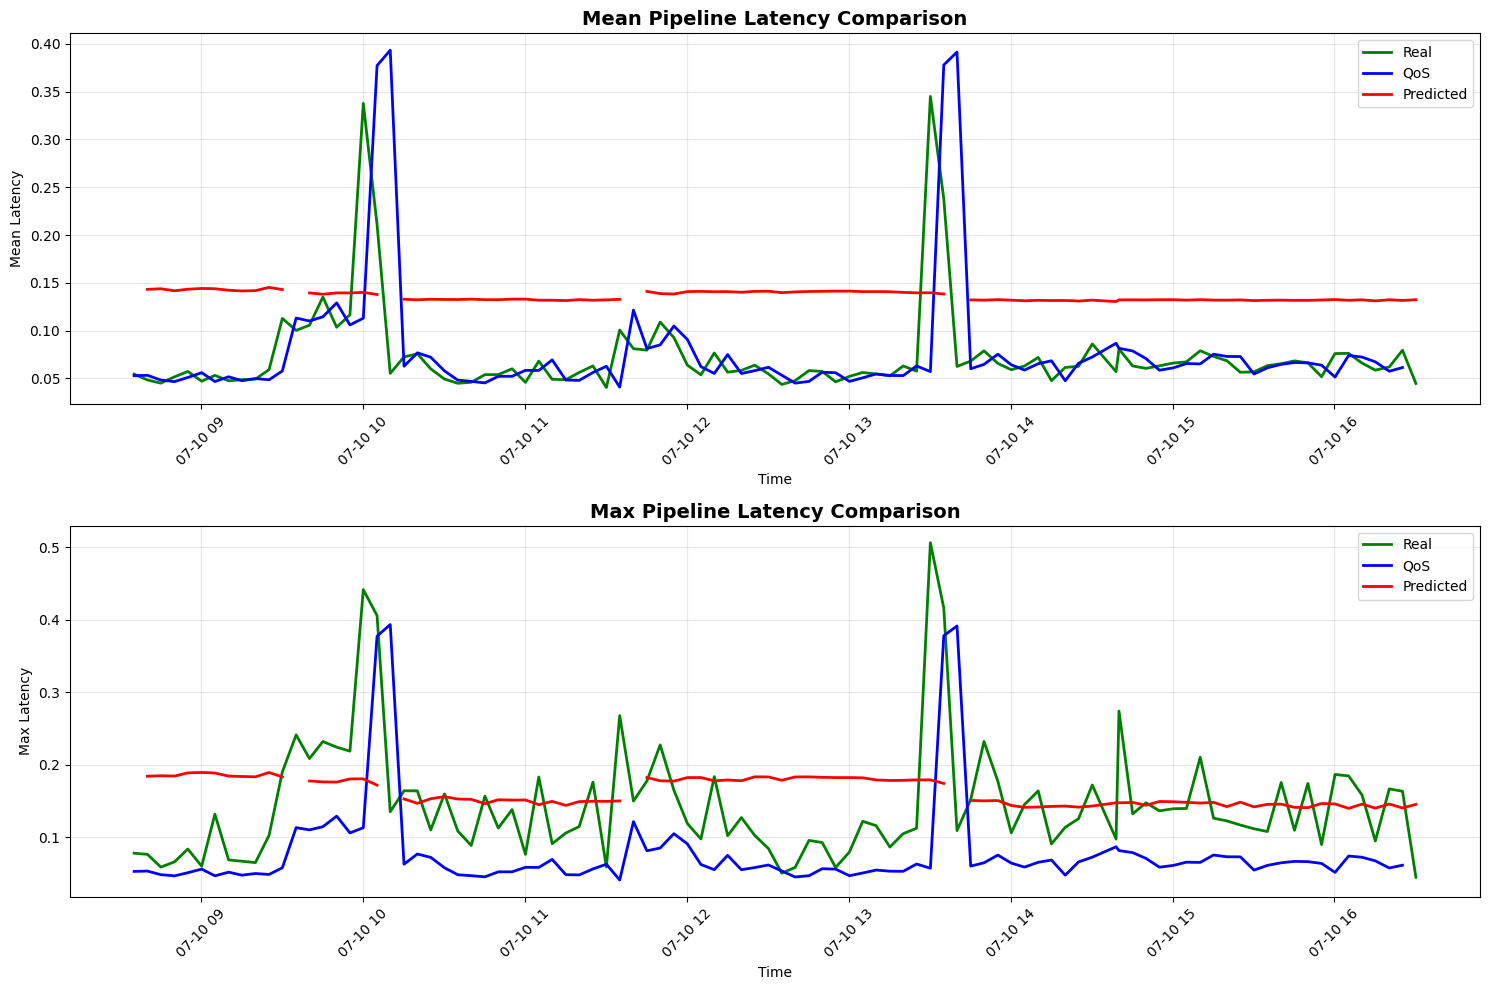

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_comparison(df_results_final):
    """
    Plot mean and max metrics comparing real, qos, and predicted values.
    
    Parameters:
    - df_results_final: DataFrame with all metrics columns
    """
    
    # Ensure start_time is datetime
    df_results_final['start_time'] = pd.to_datetime(df_results_final['start_time'])
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Mean values
    ax1.plot(df_results_final['start_time'], 
             df_results_final['real_future_values_5_min_mean'], 
             label='Real', linewidth=2, color='green')
    
    ax1.plot(df_results_final['start_time'], 
             df_results_final['qos_0'], 
             label='QoS', linewidth=2, color='blue')
    
    ax1.plot(df_results_final['start_time'], 
             df_results_final['mean_predicted'], 
             label='Predicted', linewidth=2, color='red')
    
    ax1.set_title('Mean Pipeline Latency Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Mean Latency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Max values
    ax2.plot(df_results_final['start_time'], 
             df_results_final['real_future_values_5_min_max'], 
             label='Real', linewidth=2, color='green')
    
    ax2.plot(df_results_final['start_time'], 
             df_results_final['qos_0'], 
             label='QoS', linewidth=2, color='blue')
    
    ax2.plot(df_results_final['start_time'], 
             df_results_final['max_predicted'], 
             label='Predicted', linewidth=2, color='red')
    
    ax2.set_title('Max Pipeline Latency Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Max Latency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Usage:
plot_metrics_comparison(df_results_final)

<Axes: >

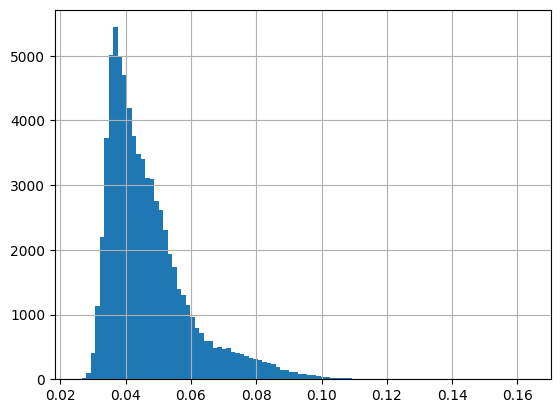

In [40]:
df[df['cluster']=='fd7816db-7948-4602-af7a-1d51900792a7'].pipelines_status_realtime_pipeline_latency.hist(bins=100)

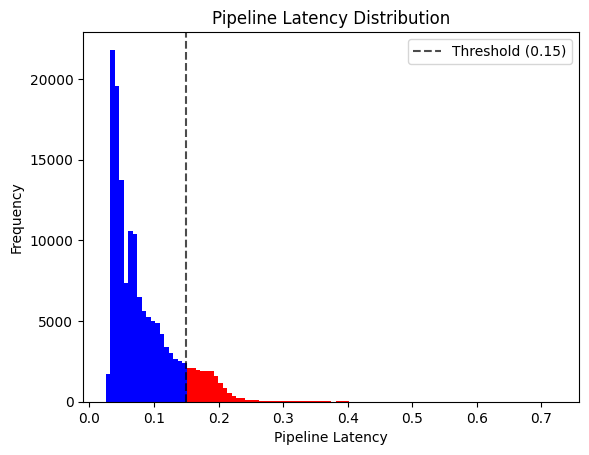

count    148222.000000
mean          0.082770
std           0.049937
min           0.025225
25%           0.043704
50%           0.066666
75%           0.107047
max           0.723460
Name: pipelines_status_realtime_pipeline_latency, dtype: float64
0.15050706545511872


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram data
data = df.pipelines_status_realtime_pipeline_latency.dropna()
counts, bins, patches = plt.hist(data, bins=100)

# Color bars based on bin centers
for i, (patch, bin_left, bin_right) in enumerate(zip(patches, bins[:-1], bins[1:])):
    bin_center = (bin_left + bin_right) / 2
    if bin_center >= 0.15:
        patch.set_facecolor('red')  # Color for values >= 0.15
    else:
        patch.set_facecolor('blue')  # Color for values < 0.15

plt.axvline(x=0.15, color='black', linestyle='--', alpha=0.7, label='Threshold (0.15)')
plt.xlabel('Pipeline Latency')
plt.ylabel('Frequency')
plt.title('Pipeline Latency Distribution')
plt.legend()
plt.show()

print(df.pipelines_status_realtime_pipeline_latency.describe())
print(df.pipelines_status_realtime_pipeline_latency.quantile(0.88))

In [13]:
import joblib
import sys
from sklearn.preprocessing import StandardScaler
sys.path.append('./informer')
# Load the scaler
scaler = joblib.load(root+'/checkpoints/'+setting+'/scaler.pkl')
# encoder= joblib.load(root+'/checkpoints/'+setting+'/onehotencoder.pkl')

# Print the mean and std shapes
print("Mean scaler shape:", scaler.mean_.shape)
print("Std scaler shape:", scaler.scale_.shape)

# Print actual values
print("\nMean scaler values:", scaler.mean_)
print("\nStd scaler values:", scaler.scale_)

# # Print the mean and std shapes
# print("\nOnehotencoder shape:", encoder.categories_[0].shape)
# print("\nOnehotencoder values:", encoder.categories_)


Mean scaler shape: (8,)
Std scaler shape: (8,)

Mean scaler values: [1.50288296e+01 9.37166278e-02 7.28110569e+00 1.07159402e+10
 7.05172434e+00 1.81092656e+09 2.60410583e+00 8.37852851e-02]

Std scaler values: [5.82954539e-01 4.72372613e-02 2.80578294e+00 2.98643139e+09
 3.14456632e+00 1.33413306e+08 6.65877690e-01 5.01705061e-02]


In [14]:
import torch
import numpy as np

def get_inverse_transformed_targets(input_data, scaler):
    """
    Inverse transform the last feature (target) of the input data using the provided scaler.
    Args:
        input_data (np.ndarray or torch.Tensor): Input data of shape (samples, timesteps, features).
        scaler (StandardScaler): Scaler used for normalization of the last 8 features.
    Returns:
        np.ndarray or torch.Tensor: Inverse transformed targets of shape (samples, timesteps, 1).
    """
    # Extract the last 8 features (scaled features) and inverse transform them
    scaled_features = input_data[:, :, 2:]  # Shape: (samples, timesteps, 8)
    
    # Reshape to 2D, inverse transform, then get target column
    original_shape = scaled_features.shape
    scaled_2d = scaled_features.reshape(-1, 8)
    inverse_scaled = scaler.inverse_transform(scaled_2d)
    inverse_targets = inverse_scaled[:, -1]  # Get last column (target)
    
    # Reshape back to (samples, timesteps)
    inverse_transformed = inverse_targets.reshape(original_shape[0], original_shape[1])
    
    # Add back the singleton dimension
    if isinstance(inverse_transformed, np.ndarray):
        inverse_transformed = inverse_transformed[..., np.newaxis]
    elif isinstance(inverse_transformed, torch.Tensor):
        inverse_transformed = inverse_transformed.unsqueeze(-1)
    
    return inverse_transformed

# Apply the transformation
inverse_targets = get_inverse_transformed_targets(inputs, scaler)
preds = preds.squeeze(-1)
trues = trues.squeeze(-1)
inverse_targets = inverse_targets.squeeze(-1)

print(preds.shape, trues.shape, inverse_targets.shape)

(29635, 10) (29635, 10) (29635, 10)


In [15]:
import matplotlib.pyplot as plt

full_df = pd.DataFrame({
    'preds': preds.flatten(),
    'trues': trues.flatten(),
    'inverse_targets': inverse_targets.flatten()
}) 


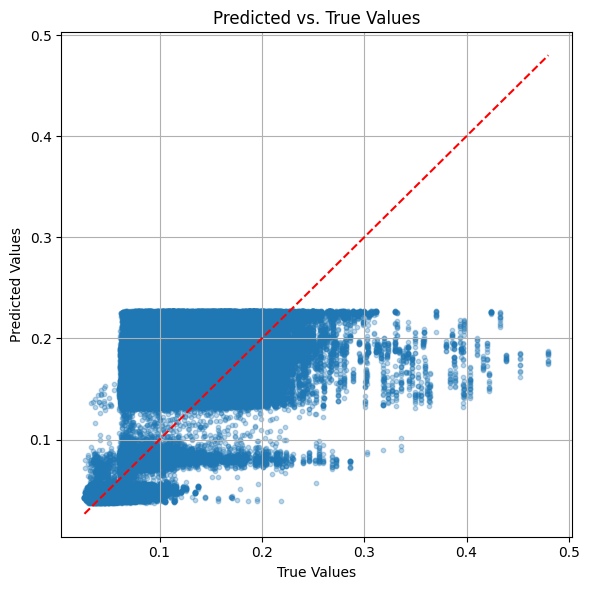

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(full_df['trues'], full_df['preds'], alpha=0.3, s=10)
plt.plot([full_df['trues'].min(), full_df['trues'].max()],
         [full_df['trues'].min(), full_df['trues'].max()],
         color='red', linestyle='--')  # perfect prediction line
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: >

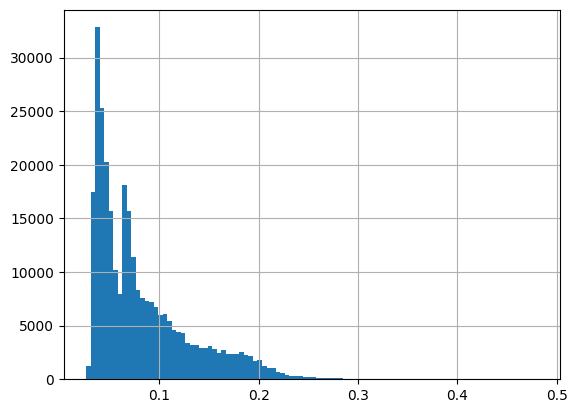

In [17]:
full_df.inverse_targets.hist(bins=100)

<Axes: >

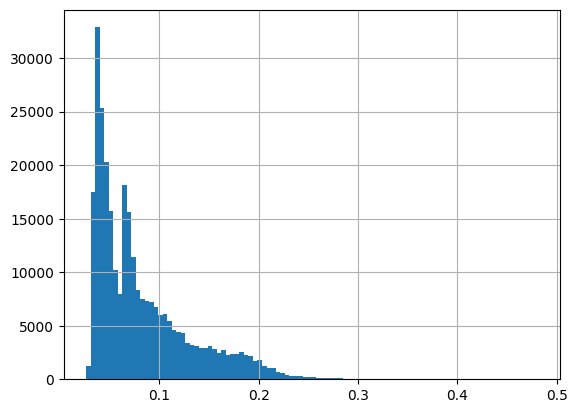

In [18]:
full_df.trues.hist(bins=100)

count    296350.000000
mean          0.096692
std           0.061329
min           0.037058
25%           0.046451
50%           0.062450
75%           0.158955
max           0.227095
Name: preds, dtype: float64


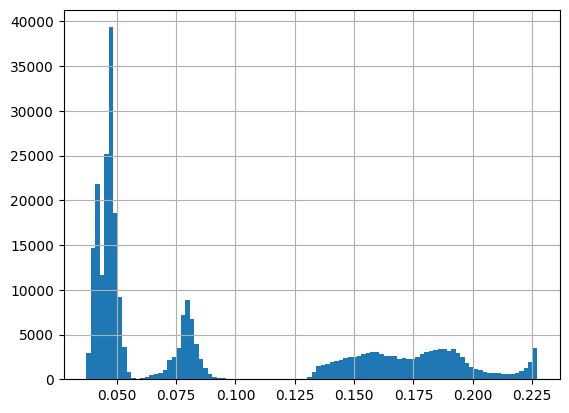

In [19]:
full_df.preds.hist(bins=100)
print(full_df.preds.describe())


In [20]:
reactive_df, proactive_df = run_experiment(inverse_targets, preds, trues)
mean_reactive_df, mean_proactive_df = run_experiment(inverse_targets, preds, trues, mean=True)
# Example of how to call it for different datasets
# summary_statistics_with_confusion_matrix(reactive_df, "Reactive Approach")
# summary_statistics_with_confusion_matrix(proactive_df, "Proactive Approach")
summary_statistics_with_confusion_matrix(mean_reactive_df, "Reactive Approach")
summary_statistics_with_confusion_matrix(mean_proactive_df, "Proactive Approach")




Reactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 55                FN: 5464
Actual No Migration    FP: 3                TN: 24113

Reactive Approach Metrics (in %):
  Accuracy: 81.55%
  Precision: 94.83%
  Recall: 1.00%
  F1 Score: 1.97%
  Specificity: 99.99%

Proactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 1272                FN: 4247
Actual No Migration    FP: 258                TN: 23858

Proactive Approach Metrics (in %):
  Accuracy: 84.80%
  Precision: 83.14%
  Recall: 23.05%
  F1 Score: 36.09%
  Specificity: 98.93%


In [21]:
reactive_df, proactive_df = run_experiment(inverse_targets, preds, trues)
mean_reactive_df, mean_proactive_df = run_experiment(inverse_targets, preds, trues, mean=True)
# Example of how to call it for different datasets
summary_statistics_with_confusion_matrix(reactive_df, "Reactive Approach")
summary_statistics_with_confusion_matrix(proactive_df, "Proactive Approach")
summary_statistics_with_confusion_matrix(mean_reactive_df, "Reactive Approach")
# summary_statistics_with_confusion_matrix(mean_proactive_df, "Proactive Approach")




Reactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 619                FN: 4900
Actual No Migration    FP: 306                TN: 23810

Reactive Approach Metrics (in %):
  Accuracy: 82.43%
  Precision: 66.92%
  Recall: 11.22%
  F1 Score: 19.21%
  Specificity: 98.73%

Proactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 1604                FN: 3915
Actual No Migration    FP: 398                TN: 23718

Proactive Approach Metrics (in %):
  Accuracy: 85.45%
  Precision: 80.12%
  Recall: 29.06%
  F1 Score: 42.65%
  Specificity: 98.35%

Reactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 55                FN: 5464
Actual No Migration    FP: 3                TN: 24113

Reactive Approach Metrics (in %):
  Accuracy: 81.55%
  Precision: 94.83%
  Recall: 1.00%
  F1 Score: 1

In [22]:
# reactive_df_min, proactive_df_min = run_minute_by_minute_experiment(inverse_targets, preds, trues)
# # mean_reactive_df, mean_proactive_df = run_experiment(inverse_targets, preds, trues, mean=True)
# summary_statistics_with_confusion_matrix_min_by_min(reactive_df_min, "Reactive Approach")
# summary_statistics_with_confusion_matrix_min_by_min(proactive_df_min, "Proactive Approach")


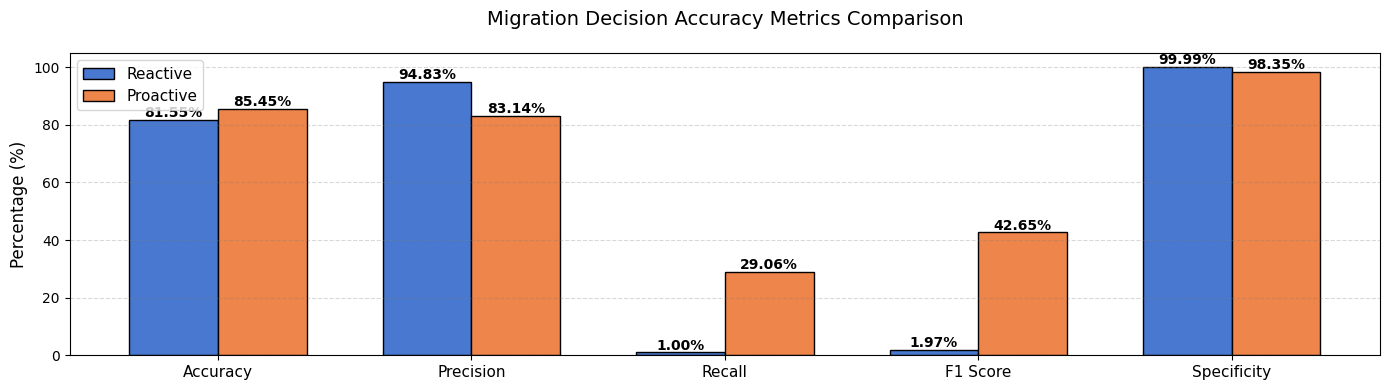

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis with transparency
fig = plt.figure(figsize=(14, 4))
fig.patch.set_alpha(0)  # Make figure background transparent
ax = plt.gca()
ax.set_alpha(0)  # Make axis background transparent

# Data preparation
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']
reactive_values = [81.55, 94.83, 1.00, 1.97, 99.99]
proactive_values = [85.45, 83.14, 29.06, 42.65, 98.35]

# Set up the bar width and positions
width = 0.35
x = np.arange(len(metrics))

# Create bars with more muted colors
plt.bar(x - width/2, reactive_values, width, label='Reactive', 
        color='#4878CF', edgecolor='black', linewidth=1)  # Muted blue
plt.bar(x + width/2, proactive_values, width, label='Proactive', 
        color='#EE854A', edgecolor='black', linewidth=1)  # Muted orange

# Customize the plot
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Migration Decision Accuracy Metrics Comparison', fontsize=14, pad=20)
plt.xticks(x, metrics, fontsize=11)
plt.legend(fontsize=11)

# Add value labels on top of each bar with bold font
def add_value_labels(x, values, offset):
    for i, v in enumerate(values):
        plt.text(x[i] + offset, v + 1, f'{v:.2f}%', 
                ha='center', 
                weight='bold',
                fontsize=10)

add_value_labels(x, reactive_values, -width/2)
add_value_labels(x, proactive_values, width/2)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3, color='gray')

plt.tight_layout()

# # Save with transparent background
# plt.savefig('migration_accuracy_metrics.png', 
#             dpi=300, 
#             bbox_inches='tight', 
#             transparent=True)

plt.show()

In [24]:
summary_statistics_with_confusion_matrix(reactive_df, "Reactive Approach")
summary_statistics_with_confusion_matrix(proactive_df, "Proactive Approach")


Reactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 619                FN: 4900
Actual No Migration    FP: 306                TN: 23810

Reactive Approach Metrics (in %):
  Accuracy: 82.43%
  Precision: 66.92%
  Recall: 11.22%
  F1 Score: 19.21%
  Specificity: 98.73%

Proactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 1604                FN: 3915
Actual No Migration    FP: 398                TN: 23718

Proactive Approach Metrics (in %):
  Accuracy: 85.45%
  Precision: 80.12%
  Recall: 29.06%
  F1 Score: 42.65%
  Specificity: 98.35%


TOP LEFT
REACTIVE:
TP+FP=619+306
PROACTIVE:
TP+FP=1604+398

TOP RIGHT:
REACTIVE:
FP=306
PROACTIVE:
FP=398


BOTTOM:
ONLY THE TIME
reactive 3990 minutes | PRAOCTIVE:2836 minutes




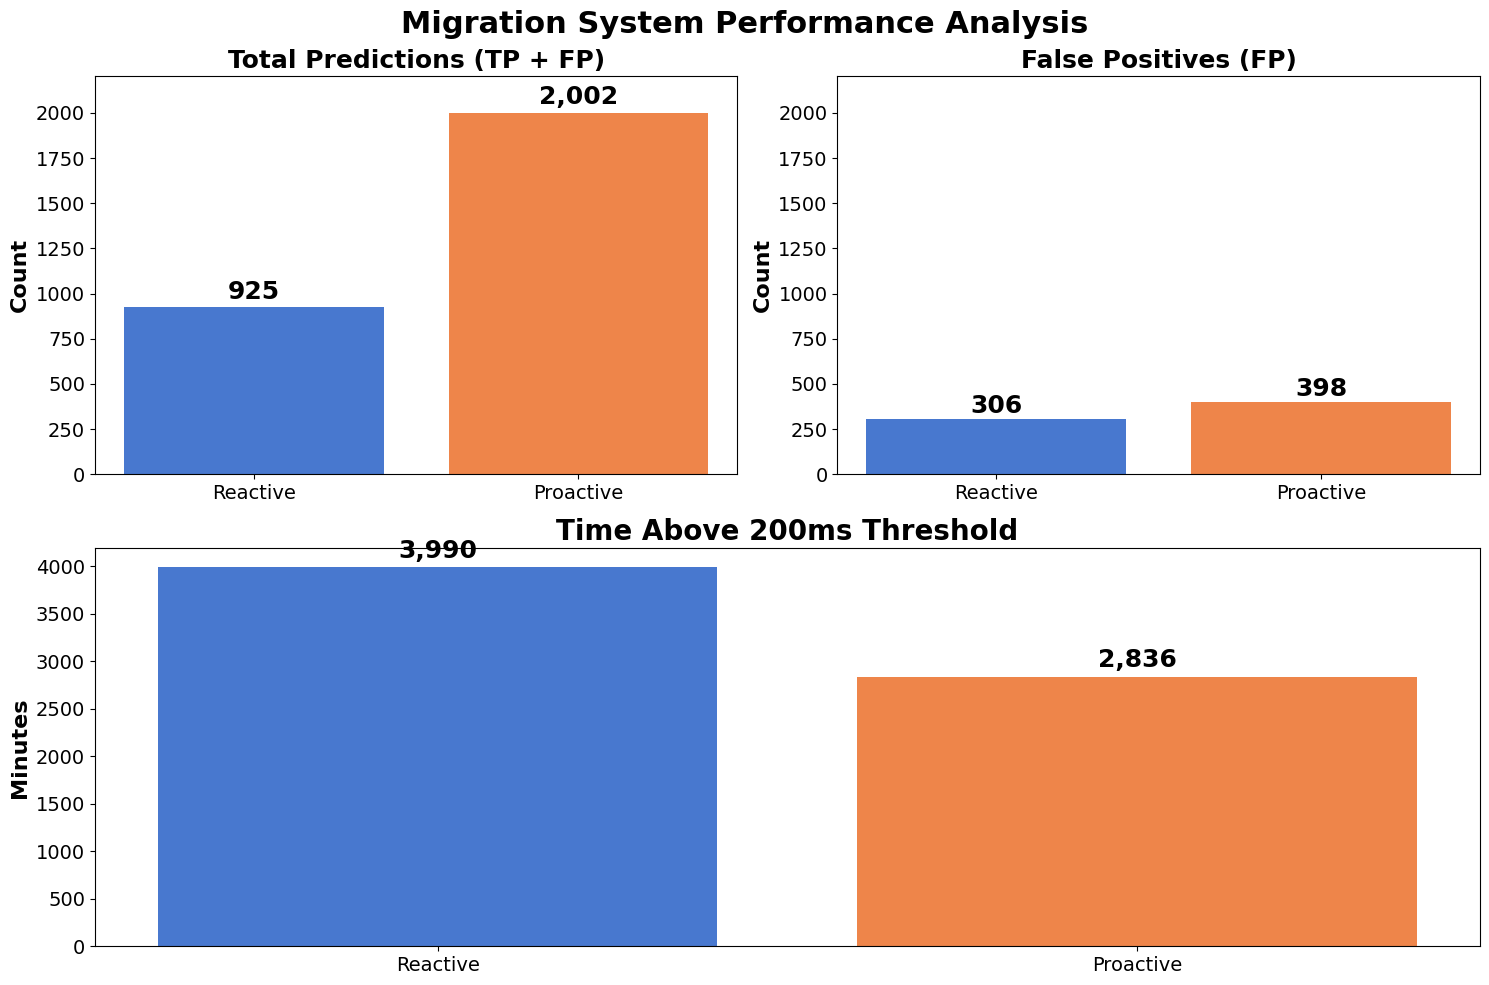

                      MIGRATION SYSTEM PERFORMANCE SUMMARY                      

TOTAL PREDICTIONS (TP + FP):
  - Reactive: 925 predictions
  - Proactive: 2,002 predictions
  - Difference: 1,077 more predictions (+116.4%)

FALSE POSITIVES (FP):
  - Reactive: 306 false positives
  - Proactive: 398 false positives
  - Difference: 92 more false positives (+30.1%)

TIME ABOVE 200ms THRESHOLD:
  - Reactive: 3,990 minutes
  - Proactive: 2,836 minutes
  - Improvement: 1,154 minutes (28.9% reduction)

FALSE POSITIVE RATES:
  - Reactive: 33.1% (306/925)
  - Proactive: 19.9% (398/2002)
  - FP Rate Difference: +13.2 percentage points

                                  KEY INSIGHTS                                  
• Proactive system makes 116.4% more predictions
• Despite more predictions, proactive system reduces time above threshold by 28.9%
• Proactive approach has a 19.9% false positive rate vs 33.1% for reactive
• Net benefit: 1,154 minutes saved with acceptable FP increase


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with subplots
fig = plt.figure(figsize=(15, 10))

# Top row: two subplots side by side
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)

# Bottom row: one subplot spanning the full width
ax3 = plt.subplot(2, 1, 2)

# Data
reactive_color = '#4878CF'
proactive_color = '#EE854A'

# TOP LEFT: Total Predictions (TP + FP)
approaches = ['Reactive', 'Proactive']
total_predictions = [619 + 306, 1604 + 398]  # TP + FP

ax1.bar(approaches, total_predictions, color=[reactive_color, proactive_color])
ax1.set_title('Total Predictions (TP + FP)', fontsize=18, fontweight='bold')
ax1.set_ylabel('Count', fontsize=16, fontweight='bold')
ax1.tick_params(axis='both', labelsize=14)

# Add value labels
for i, v in enumerate(total_predictions):
    ax1.text(i, v + 20, f'{v:,}', ha='center', va='bottom', fontweight='bold', fontsize=18)

# TOP RIGHT: False Positives (FP)
fp_values = [306, 398]

ax2.bar(approaches, fp_values, color=[reactive_color, proactive_color])
ax2.set_title('False Positives (FP)', fontsize=18, fontweight='bold')
ax2.set_ylabel('Count', fontsize=16, fontweight='bold')
ax2.tick_params(axis='both', labelsize=14)

# Add value labels
for i, v in enumerate(fp_values):
    ax2.text(i, v + 5, f'{v:,}', ha='center', va='bottom', fontweight='bold', fontsize=18)

# Set shared y-axis limits for top charts
max_value = max(max(total_predictions), max(fp_values))
y_limit = max_value * 1.1  # Add 10% padding
ax1.set_ylim(0, y_limit)
ax2.set_ylim(0, y_limit)

# BOTTOM: Time Above Threshold (spanning across bottom)
time_values = [3990, 2836]

ax3.bar(approaches, time_values, color=[reactive_color, proactive_color])
ax3.set_title('Time Above 200ms Threshold', fontsize=20, fontweight='bold')
ax3.set_ylabel('Minutes', fontsize=16, fontweight='bold')
ax3.tick_params(axis='both', labelsize=14)

# Add value labels
for i, v in enumerate(time_values):
    ax3.text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold', fontsize=18)

# Overall title
fig.suptitle('Migration System Performance Analysis', fontsize=22, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 80)
print("MIGRATION SYSTEM PERFORMANCE SUMMARY".center(80))
print("=" * 80)

print(f"\nTOTAL PREDICTIONS (TP + FP):")
print(f"  - Reactive: {total_predictions[0]:,} predictions")
print(f"  - Proactive: {total_predictions[1]:,} predictions")
print(f"  - Difference: {total_predictions[1] - total_predictions[0]:,} more predictions (+{((total_predictions[1] - total_predictions[0])/total_predictions[0]*100):,.1f}%)")

print(f"\nFALSE POSITIVES (FP):")
print(f"  - Reactive: {fp_values[0]:,} false positives")
print(f"  - Proactive: {fp_values[1]:,} false positives") 
print(f"  - Difference: {fp_values[1] - fp_values[0]:,} more false positives (+{((fp_values[1] - fp_values[0])/fp_values[0]*100):,.1f}%)")

print(f"\nTIME ABOVE 200ms THRESHOLD:")
print(f"  - Reactive: {time_values[0]:,} minutes")
print(f"  - Proactive: {time_values[1]:,} minutes")
print(f"  - Improvement: {time_values[0] - time_values[1]:,} minutes ({((time_values[0] - time_values[1])/time_values[0]*100):,.1f}% reduction)")

print(f"\nFALSE POSITIVE RATES:")
reactive_fp_rate = (fp_values[0] / total_predictions[0]) * 100
proactive_fp_rate = (fp_values[1] / total_predictions[1]) * 100
print(f"  - Reactive: {reactive_fp_rate:.1f}% ({fp_values[0]}/{total_predictions[0]})")
print(f"  - Proactive: {proactive_fp_rate:.1f}% ({fp_values[1]}/{total_predictions[1]})")
print(f"  - FP Rate Difference: {reactive_fp_rate - proactive_fp_rate:+.1f} percentage points")

print("\n" + "=" * 80)
print("KEY INSIGHTS".center(80))
print("=" * 80)
print(f"• Proactive system makes {((total_predictions[1]/total_predictions[0]) - 1)*100:.1f}% more predictions")
print(f"• Despite more predictions, proactive system reduces time above threshold by {((time_values[0] - time_values[1])/time_values[0]*100):,.1f}%")
print(f"• Proactive approach has a {proactive_fp_rate:.1f}% false positive rate vs {reactive_fp_rate:.1f}% for reactive")
print(f"• Net benefit: {time_values[0] - time_values[1]:,} minutes saved with acceptable FP increase")

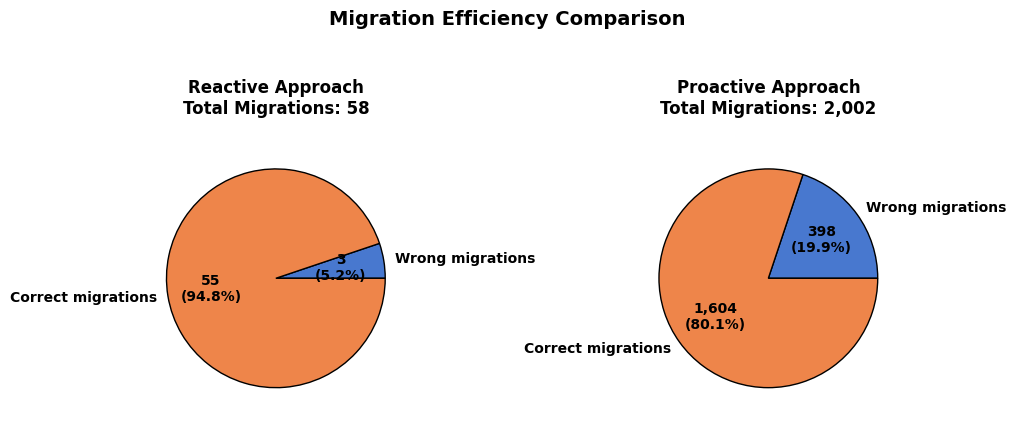

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.patch.set_alpha(0)

# Data for both approaches - reversed to match correct order
reactive_data = [3, 55]  # [Predicted, Missed] - was [Missed, Predicted]
proactive_data = [398, 1604]  # [Predicted, Missed] - was [Missed, Predicted]
labels = ['Wrong migrations','Correct migrations']
colors = ['#4878CF', '#EE854A']

def pie_with_border(ax, data, title):
    def make_autopct(values):
        def my_autopct(pct):
            val = values[int(pct*len(values)/100)]
            return f'{int(val):,}\n({pct:.1f}%)'
        return my_autopct
    
    wedges, texts, autotexts = ax.pie(data, 
                                     labels=labels, 
                                     colors=colors,
                                     autopct=make_autopct(data),
                                     textprops={'fontsize': 10, 'weight': 'bold'})
    
    for wedge in wedges:
        wedge.set_edgecolor('black')
        wedge.set_linewidth(1)
    
    ax.set_title(f'{title}\nTotal Migrations: {sum(data):,}',
                pad=20, fontsize=12, weight='bold')
    ax.set_alpha(0)

pie_with_border(ax1, reactive_data, 'Reactive Approach')
pie_with_border(ax2, proactive_data, 'Proactive Approach')

fig.suptitle('Migration Efficiency Comparison', fontsize=14, weight='bold', y=1.05)

for ax in [ax1, ax2]:
    ax.set_frame_on(False)

plt.tight_layout()
plt.show()

In [27]:
summary_statistics_with_confusion_matrix(mean_reactive_df, "Reactive Approach")
summary_statistics_with_confusion_matrix(proactive_df, "Proactive Approach")


Reactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 55                FN: 5464
Actual No Migration    FP: 3                TN: 24113

Reactive Approach Metrics (in %):
  Accuracy: 81.55%
  Precision: 94.83%
  Recall: 1.00%
  F1 Score: 1.97%
  Specificity: 99.99%

Proactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 1604                FN: 3915
Actual No Migration    FP: 398                TN: 23718

Proactive Approach Metrics (in %):
  Accuracy: 85.45%
  Precision: 80.12%
  Recall: 29.06%
  F1 Score: 42.65%
  Specificity: 98.35%


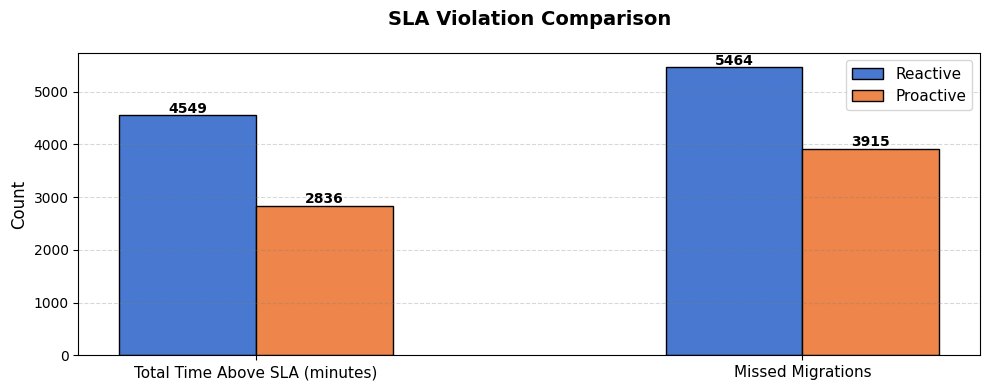

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis with transparency
fig = plt.figure(figsize=(10, 4))
fig.patch.set_alpha(0)  # Make figure background transparent
ax = plt.gca()
ax.set_alpha(0)  # Make axis background transparent

# Data for SLA Violations
categories = ['Total Time Above SLA (minutes)', 'Missed Migrations']
reactive_values = [4549, 5464]
proactive_values = [2836, 3915]

x = np.arange(len(categories))
width = 0.25

plt.bar(x - width/2, reactive_values, width, label='Reactive',
       color='#4878CF', edgecolor='black', linewidth=1)
plt.bar(x + width/2, proactive_values, width, label='Proactive',
       color='#EE854A', edgecolor='black', linewidth=1)

plt.ylabel('Count', fontsize=12)
plt.title('SLA Violation Comparison', fontsize=14, pad=20, weight='bold')
plt.xticks(x, categories, fontsize=11)
plt.legend(fontsize=11)

# Add value labels
def add_value_labels(x, values, offset):
   for i, v in enumerate(values):
       plt.text(x[i] + offset, v + 50, f'{v}',
               ha='center',
               weight='bold',
               fontsize=10)

add_value_labels(x, reactive_values, -width/2)
add_value_labels(x, proactive_values, width/2)

plt.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
plt.tight_layout()

plt.show()

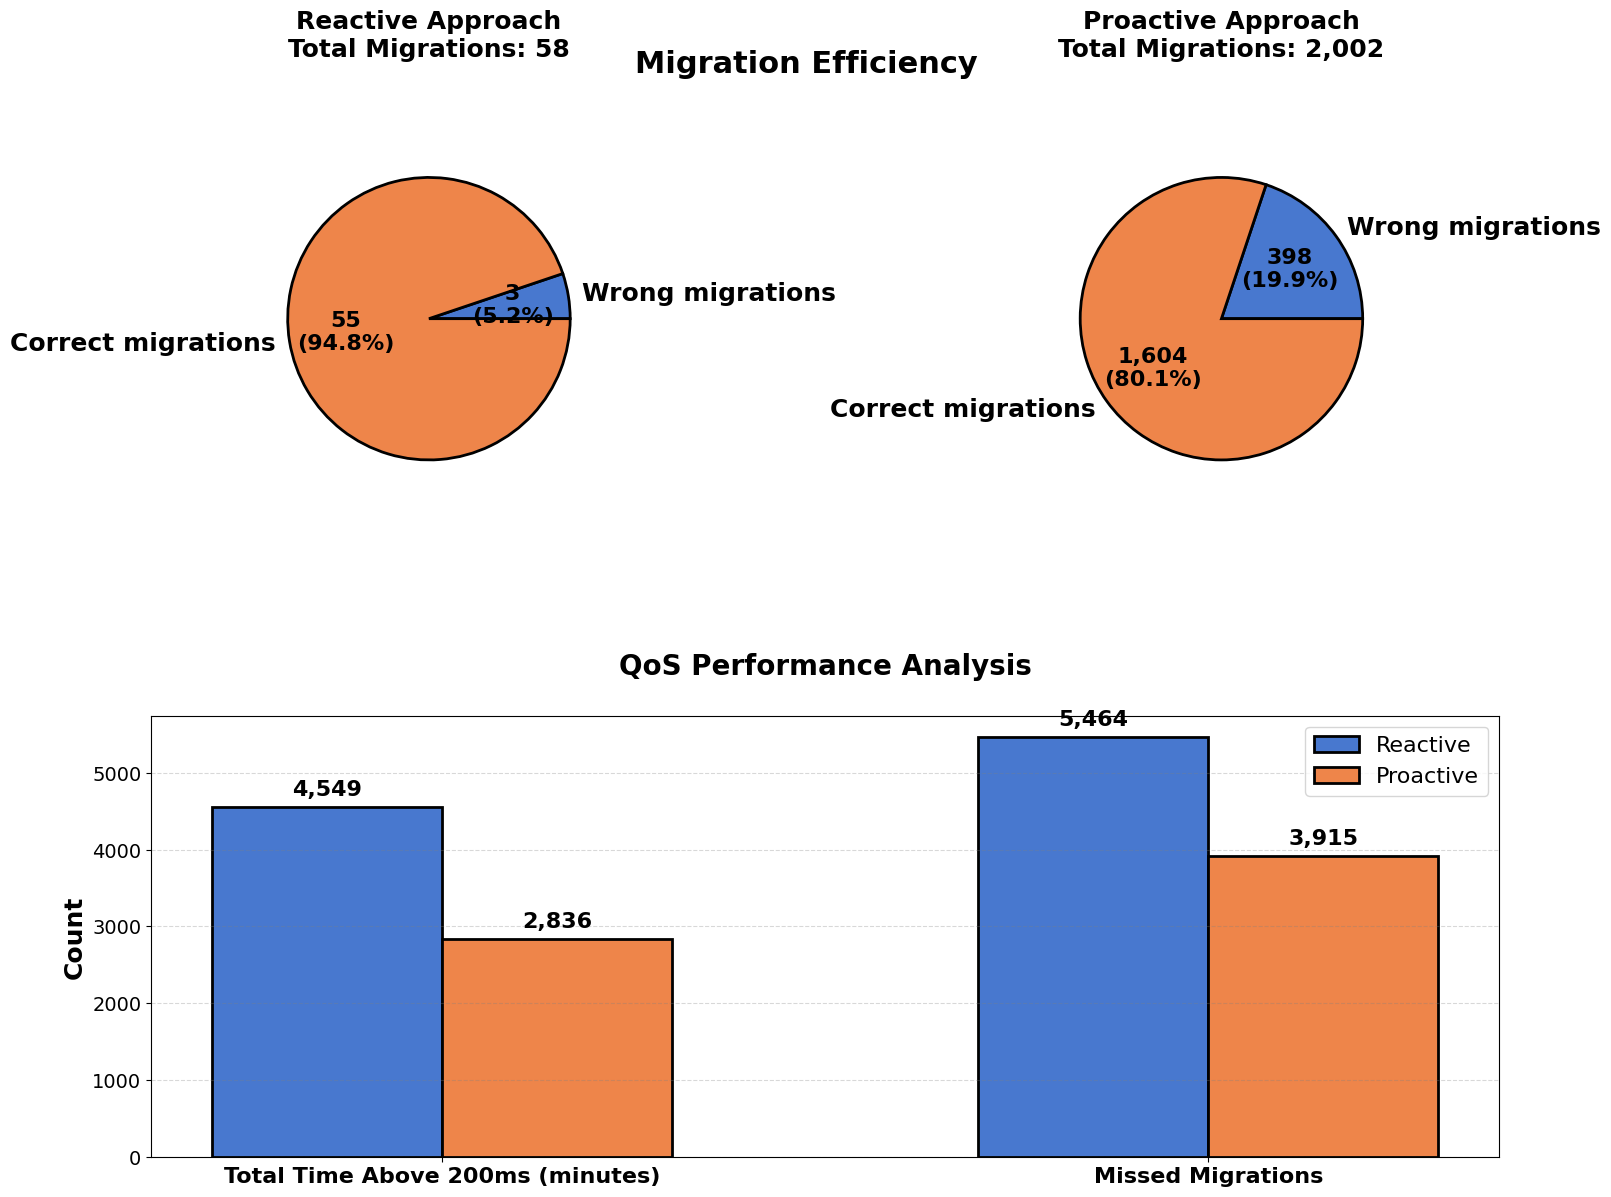

                     MIGRATION EFFICIENCY SUMMARY                     
Reactive Approach:
  - Total migrations: 58
  - Correct migrations: 55 (94.8%)
  - Wrong migrations: 3 (5.2%)

Proactive Approach:
  - Total migrations: 2,002
  - Correct migrations: 1,604 (80.1%)
  - Wrong migrations: 398 (19.9%)

                        SLA VIOLATION SUMMARY                         
Time Above SLA:
  - Reactive: 4,549 minutes
  - Proactive: 2,836 minutes
  - Improvement: 1,713 minutes (37.7% reduction)

Missed Migrations:
  - Reactive: 5,464
  - Proactive: 3,915
  - Improvement: 1,549 (28.3% reduction)

                             KEY INSIGHTS                             
• Proactive approach handles 34.5x more migrations
• SLA compliance time improved by 37.7%
• Migration accuracy: Reactive 94.8% vs Proactive 80.1%


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 3 subplots: 2 pie charts on top, 1 bar chart below
fig = plt.figure(figsize=(16, 12))
fig.patch.set_alpha(0)

# Create subplot layout: 2 rows, 2 columns
# Top row: two pie charts (smaller)
# Bottom row: one bar chart spanning both columns

# Pie chart data
reactive_data = [3, 55]  # [Wrong migrations, Correct migrations]
proactive_data = [398, 1604]  # [Wrong migrations, Correct migrations]
labels = ['Wrong migrations', 'Correct migrations']
colors = ['#4878CF', '#EE854A']

def pie_with_border(ax, data, title):
    def make_autopct(values):
        def my_autopct(pct):
            val = values[int(pct*len(values)/100)]
            return f'{int(val):,}\n({pct:.1f}%)'
        return my_autopct
    
    wedges, texts, autotexts = ax.pie(data,
                                     labels=labels,
                                     colors=colors,
                                     autopct=make_autopct(data),
                                     textprops={'fontsize': 16, 'weight': 'bold'},
                                     labeldistance=1.1,
                                     radius=0.8)  # Make pie smaller
    
    for wedge in wedges:
        wedge.set_edgecolor('black')
        wedge.set_linewidth(2)
    
    # Increase label font sizes
    for text in texts:
        text.set_fontsize(18)
        text.set_weight('bold')
    
    for autotext in autotexts:
        autotext.set_fontsize(16)
        autotext.set_weight('bold')
    
    ax.set_title(f'{title}\nTotal Migrations: {sum(data):,}',
                pad=30, fontsize=18, weight='bold')
    ax.set_alpha(0)

# Create pie chart subplots with adjusted positioning
ax1 = plt.subplot(2, 2, 1)
pie_with_border(ax1, reactive_data, 'Reactive Approach')

ax2 = plt.subplot(2, 2, 2)
pie_with_border(ax2, proactive_data, 'Proactive Approach')

# Create bar chart subplot spanning the bottom row
ax3 = plt.subplot(2, 1, 2)
ax3.set_alpha(0)

# Data for SLA Violations
categories = ['Total Time Above 200ms (minutes)', 'Missed Migrations']
reactive_values = [4549, 5464]
proactive_values = [2836, 3915]

x = np.arange(len(categories))
width = 0.3

bars1 = ax3.bar(x - width/2, reactive_values, width, label='Reactive',
                color='#4878CF', edgecolor='black', linewidth=2)
bars2 = ax3.bar(x + width/2, proactive_values, width, label='Proactive',
                color='#EE854A', edgecolor='black', linewidth=2)

ax3.set_ylabel('Count', fontsize=18, weight='bold')
ax3.set_title('QoS Performance Analysis', fontsize=20, pad=30, weight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(categories, fontsize=16, weight='bold')
ax3.tick_params(axis='y', labelsize=14)
ax3.legend(fontsize=16, loc='upper right')

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 100,
                f'{int(height):,}',
                ha='center', va='bottom',
                weight='bold', fontsize=16)

add_value_labels(bars1)
add_value_labels(bars2)

ax3.grid(axis='y', linestyle='--', alpha=0.3, color='gray')

# Set overall title
fig.suptitle('Migration Efficiency', 
             fontsize=22, weight='bold', y=0.96)

# Remove frame from pie chart axes
for ax in [ax1, ax2]:
    ax.set_frame_on(False)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4)  # Make room for the main title and increase spacing
plt.show()

# Print summary statistics with larger, bold formatting
print("=" * 70)
print("MIGRATION EFFICIENCY SUMMARY".center(70))
print("=" * 70)
print(f"Reactive Approach:")
print(f"  - Total migrations: {sum(reactive_data):,}")
print(f"  - Correct migrations: {reactive_data[1]:,} ({reactive_data[1]/sum(reactive_data)*100:.1f}%)")
print(f"  - Wrong migrations: {reactive_data[0]:,} ({reactive_data[0]/sum(reactive_data)*100:.1f}%)")

print(f"\nProactive Approach:")
print(f"  - Total migrations: {sum(proactive_data):,}")
print(f"  - Correct migrations: {proactive_data[1]:,} ({proactive_data[1]/sum(proactive_data)*100:.1f}%)")
print(f"  - Wrong migrations: {proactive_data[0]:,} ({proactive_data[0]/sum(proactive_data)*100:.1f}%)")

print("\n" + "=" * 70)
print("SLA VIOLATION SUMMARY".center(70))
print("=" * 70)
print(f"Time Above SLA:")
print(f"  - Reactive: {reactive_values[0]:,} minutes")
print(f"  - Proactive: {proactive_values[0]:,} minutes")
print(f"  - Improvement: {reactive_values[0] - proactive_values[0]:,} minutes ({(reactive_values[0] - proactive_values[0])/reactive_values[0]*100:.1f}% reduction)")

print(f"\nMissed Migrations:")
print(f"  - Reactive: {reactive_values[1]:,}")
print(f"  - Proactive: {proactive_values[1]:,}")
print(f"  - Improvement: {reactive_values[1] - proactive_values[1]:,} ({(reactive_values[1] - proactive_values[1])/reactive_values[1]*100:.1f}% reduction)")

print("\n" + "=" * 70)
print("KEY INSIGHTS".center(70))
print("=" * 70)
print(f"• Proactive approach handles {sum(proactive_data)/sum(reactive_data):.1f}x more migrations")
print(f"• SLA compliance time improved by {(reactive_values[0] - proactive_values[0])/reactive_values[0]*100:.1f}%")
print(f"• Migration accuracy: Reactive {reactive_data[1]/sum(reactive_data)*100:.1f}% vs Proactive {proactive_data[1]/sum(proactive_data)*100:.1f}%")

ValueError: x and y must have same first dimension, but have shapes (3,) and (10,)

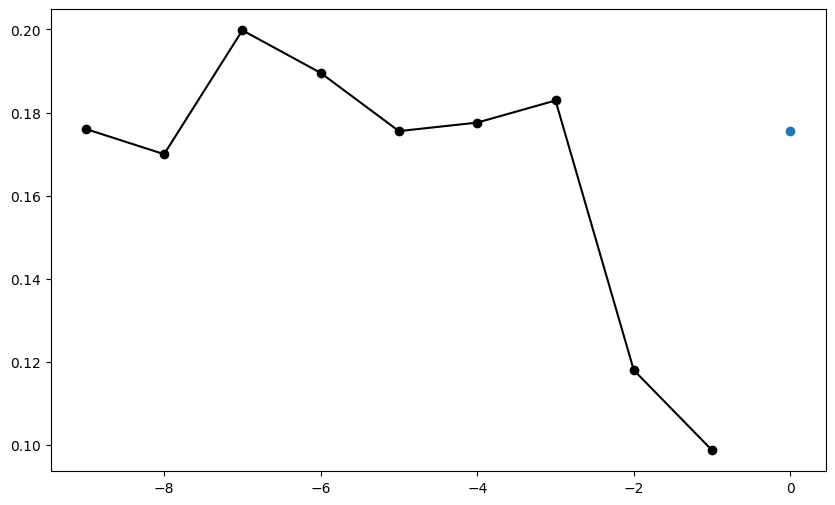

In [30]:
import numpy as np
import matplotlib.pyplot as plt
def plot_sample_mismatch(reactive_df, proactive_df, input_data, pred_data, true_data):
    """
    Plot a sample where the reactive approach predicted no migration but proactive predicted migration.
    Input shapes:
    - input_data: (N, 20) - full history
    - pred_data: (N, 3) - predictions for next 3 steps
    - true_data: (N, 3) - actual values for next 3 steps
    """
    # Identify the index where reactive predicted no migration and proactive predicted migration
    mismatch_index = np.where((reactive_df['migration'] == False) & (proactive_df['migration'] == True))[0]
    
    if len(mismatch_index) == 0:
        print("No samples found where reactive predicted no migration and proactive predicted migration.")
        return
        
    # Select a sample (taking the first one as an example)
    sample_idx = mismatch_index[13]  # Change the index if needed
    
    # Extract the relevant data
    input_sample = input_data[sample_idx, -10:]  # Take last 10 steps of history
    pred_sample = pred_data[sample_idx]          # Predicted next 3 steps (Proactive)
    true_sample = true_data[sample_idx]          # Actual next 3 steps
    
    # Plot the time series
    plt.figure(figsize=(10, 6))
    
    # Plot the input points
    input_time = np.arange(-9, 1)  # -9 to 0 for the last 10 steps
    input_color = 'black'
    last_input_color = '#1f77b4'
    
    # Plot all but the last input point
    plt.plot(input_time[:-1], input_sample[:-1], 
             label='Input (Past Steps)', 
             marker='o', 
             color=input_color)
    
    # Plot the last input point separately
    plt.plot(input_time[-1:], input_sample[-1:], 
             label='Input (Current Step)', 
             marker='o', 
             color=last_input_color)
    
    # Plot the true future values
    plt.plot(range(1, 4), true_sample, 
             label='True Future (Next 3 Steps)', 
             marker='x', 
             color='green')
    
    # Plot the proactive predicted future values
    plt.plot(range(1, 4), pred_sample, 
             label='Proactive Prediction (Next 3 Steps)', 
             marker='o', 
             linestyle='--', 
             color='#ff7f0e')
    
    # Add horizontal line for SLA threshold
    plt.axhline(y=SLA_THRESHOLD, 
                color='red', 
                linestyle='--', 
                label='SLA Threshold')
    
    # Add annotations
    plt.text(0.845, 0.4, 
             'Reactive: No Migration', 
             transform=plt.gca().transAxes,
             fontsize=12, 
             color=last_input_color, 
             verticalalignment='top', 
             horizontalalignment='right', 
             bbox=dict(facecolor='white', alpha=0.6))
             
    plt.text(0.75, 0.8, 
             'Proactive: Migration Triggered', 
             transform=plt.gca().transAxes,
             fontsize=12, 
             color='#ff7f0e', 
             verticalalignment='top', 
             horizontalalignment='right', 
             bbox=dict(facecolor='white', alpha=0.6))
    
    # Add labels, title, and legend
    plt.xlabel("Time Steps")
    plt.ylabel("PredictionTime")
    plt.title("Sample with Reactive and Proactive Mismatch")
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_sample_mismatch(reactive_df, proactive_df, inverse_targets, preds, trues)


After analysing the results, we can conclude that using the proactive approach improves the migrations compared to a reactive approach.


Looking at the **Precision** we see a high value for **reactive approach (76.21%)**, which indicates a high correlation between the target value in the previous timestep and the future steps, this is know and expected. Having the last value of PredictionTime above SLA it's a good indicator that the following steps might also be above SLA, thus being a solid logic to use as baseline for the reactive approach. Even so, we see that by using a **proactive approach**, we are able to increase this **Precision up to 84.34%**. This improvement manifests the higher confidence of our model in forecasting high PredictionTime future steps compared to simply using the last value. Our model is more sure that those predicted migrations will be actual migrations. This is positive, as it means we will have fewer mistakes when decision is to migrate, incurring fewer unneeded migration costs.  

Looking at the **Recall**, we see much lower values both from reactive and proactive approaches. This indicates that both approaches suffer to capture the actual migrations. On the one hand, **Reactive approach has 41.72% Recall**, which means that less than half of the actual migrations are captured and triggered by this approach. A potential way to improve this would be to check not only the last step, but also the previous ones. However, this would probably decrease the **Precision** of the reactive approach, which is specially harmful due to having empty migration costs (not linked to the benefits of needing the migration). On the other hand, **Recall improves to 54.66% with the proactive approach** now being able to identify more than half of the actual migrations. Meaning we have an improvement on migration detection, even though the value is still low and many migrations are not detected. 

Finally, the **Specificity of both approaches is really high, with 94.46% and 95.69% values for Reactive and Proactive approaches respectively.** This means that both approaches are able to identify when a migration is not needed. This behaviour is expected seing how both approaches suffer to identify actual migrations and tend to predict No Migration policies.

The **F1 Score are 53.93% and 66.33% for Reactive and Proactive approaches respectively**, confirming that the proactive approach outperforms when identifying the future migrations.

We will now test a **different policy for Proactive Approach**, using %CI of the error as extra information for taking the migration decision instead of using the direct prediction of the model for the proactive. This will likely improve the Precision of the model but further reduce the Recall, making our predictions more confident but decreasing the identification of actual migrations. We will then compare F1 scores to see which approach is better. 


#### Amount of time above SLA

Check the total amount of time above SLA for both approaches.

For the reactive approach:
   - Migrations not predicted: the true value went above SLA and it was not detected. Sum the amount of minutes that each migration not predicted has been above SLA.

For the proactive approach:
   - Migrations not predicted: the true value went above SLA and it was not detected. Sum the amount of minutes that each migration not predicted has been above SLA.

In [ ]:
reactive_df.future_incidents.max()

8


Reactive Approach             Proactive Approach
Total time above SLA (not predicted):3989.5 minutes | Total time above SLA (not predicted):2835.5 minutes
Total migrations not predicted:4900 | Total migrations not predicted:3915
Past values above SLA (not avoided):9250 minutes | No past values for proactive  

Percentage distribution of time above SLA (when migration not predicted):
Value 1                        61.08% | Value 1                        68.79%
Value 2                        22.98% | Value 2                        21.05%
Value 3                        10.06% | Value 3                        7.25%


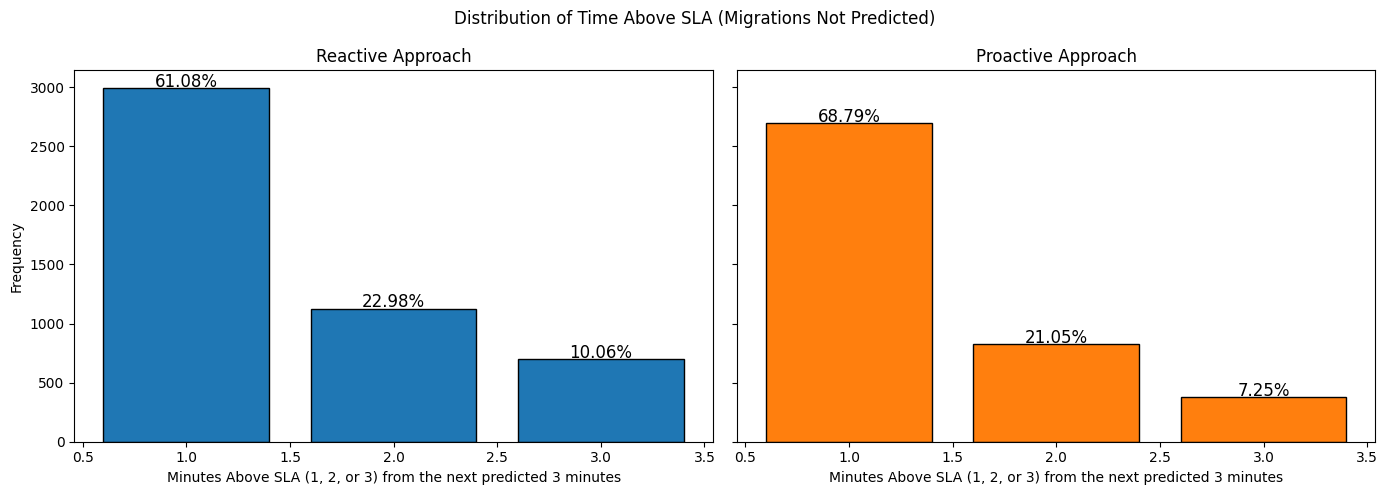

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_time_above_sla(df, approach_name="Approach"):
    """
    Calculate and analyze the total amount of time above SLA for:
    - Migrations not predicted (true values went above SLA but migration was not triggered).
    - Past values that went above SLA and could not be avoided (for reactive approach).
    Returns the data for comparative visualization.
    """
    # Total time for migrations not predicted (i.e., true value above SLA but no migration)
    time_above_sla_not_predicted = (df['migration'] == False) & (df['future_incidents'] > 0)
    time_above_sla_distribution = df.loc[time_above_sla_not_predicted, 'future_incidents']
    
    # For reactive approach, past values above SLA that have happened and could not be avoided
    past_values_above_sla = np.nan
    if 'prior_incidents' in df.columns:
        past_values_above_sla = df['prior_incidents'].sum()
    
    # Output total values
    total_migrations_not_predicted = time_above_sla_distribution.count()
    total_time_above_sla_not_predicted = time_above_sla_distribution.sum()/2 # Each timestamp is 30s, we show total time in minutes
    
    # Calculate the percentage distribution of values (1, 2, or 3)
    value_counts = time_above_sla_distribution.value_counts(normalize=True) * 100
    
    # Return statistics for side-by-side comparison
    return {
        'total_time_above_sla_not_predicted': total_time_above_sla_not_predicted,
        'total_migrations_not_predicted': total_migrations_not_predicted,
        'value_counts': value_counts,
        'past_values_above_sla': past_values_above_sla,
        'time_above_sla_distribution': time_above_sla_distribution
    }

def print_side_by_side(reactive_stats, proactive_stats):
    """
    Print and plot the comparison of the reactive and proactive approaches side by side,
    including the percentage distribution of values inside the histograms.
    """
    # Print summary information
    print(f"\n{'Reactive Approach':<30}{'Proactive Approach'}")
    print(f"{'Total time above SLA (not predicted):':<30}{reactive_stats['total_time_above_sla_not_predicted']} minutes"
          f" | {'Total time above SLA (not predicted):':<30}{proactive_stats['total_time_above_sla_not_predicted']} minutes")
    
    print(f"{'Total migrations not predicted:':<30}{reactive_stats['total_migrations_not_predicted']}"
          f" | {'Total migrations not predicted:':<30}{proactive_stats['total_migrations_not_predicted']}")
    
    if reactive_stats['past_values_above_sla'] is not np.nan:
        print(f"{'Past values above SLA (not avoided):':<30}{reactive_stats['past_values_above_sla']} minutes"
              f" | {'No past values for proactive':<30}")
    
    # Print the percentage distribution of values
    print("\nPercentage distribution of time above SLA (when migration not predicted):")
    for value in [1, 2, 3]:
        reactive_value = reactive_stats['value_counts'].get(value, 0)
        proactive_value = proactive_stats['value_counts'].get(value, 0)
        print(f"Value {value:<25}{reactive_value:.2f}%"
              f" | Value {value:<25}{proactive_value:.2f}%")

    # Plot side by side histograms
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    
    # Reactive Approach
    counts_reactive, bins_reactive, _ = axes[0].hist(reactive_stats['time_above_sla_distribution'], 
                                                     bins=[1, 2, 3, 4], edgecolor='black', align='left', rwidth=0.8, color='#1f77b4')
    axes[0].set_title('Reactive Approach')
    axes[0].set_xlabel('Minutes Above SLA (1, 2, or 3) from the next predicted 3 minutes')
    axes[0].set_ylabel('Frequency')

    # Add percentage annotations inside the plot for Reactive Approach
    for i, count in enumerate(counts_reactive):
        percentage = reactive_stats['value_counts'].get(i + 1, 0)
        if count > 0:
            axes[0].text(i + 1, count + 10, f"{percentage:.2f}%", ha='center', fontsize=12)

    # Proactive Approach
    counts_proactive, bins_proactive, _ = axes[1].hist(proactive_stats['time_above_sla_distribution'], 
                                                       bins=[1, 2, 3, 4], edgecolor='black', align='left', rwidth=0.8, color='#ff7f0e')
    axes[1].set_title('Proactive Approach')
    axes[1].set_xlabel('Minutes Above SLA (1, 2, or 3) from the next predicted 3 minutes')

    # Add percentage annotations inside the plot for Proactive Approach
    for i, count in enumerate(counts_proactive):
        percentage = proactive_stats['value_counts'].get(i + 1, 0)
        if count > 0:
            axes[1].text(i + 1, count + 10, f"{percentage:.2f}%", ha='center', fontsize=12)
    
    plt.suptitle('Distribution of Time Above SLA (Migrations Not Predicted)')
    plt.tight_layout()
    plt.show()

# Example usage with reactive and proactive data
reactive_stats = calculate_time_above_sla(reactive_df, "Reactive Approach")
proactive_stats = calculate_time_above_sla(proactive_df, "Proactive Approach")

# Print and plot the results side by side
print_side_by_side(reactive_stats, proactive_stats)


In [ ]:
print(reactive_df.head())
print(mean_reactive_df.head())

   prior_incidents  migration  unnecessary_migration  future_incidents
0                0      False                  False                 0
1                0      False                  False                 0
2                0      False                  False                 1
3                0      False                  False                 1
4                0      False                  False                 1
   prior_incidents  migration  unnecessary_migration  future_incidents
0                0      False                  False                 0
1                0      False                  False                 0
2                0      False                  False                 1
3                0      False                  False                 1
4                0      False                  False                 1


In [ ]:
reactive_df, proactive_df = run_experiment(inverse_targets, preds, trues)
mean_reactive_df, mean_proactive_df = run_experiment(inverse_targets, preds, trues, mean=True)
# Example of how to call it for different datasets
summary_statistics_with_confusion_matrix(reactive_df, "Reactive Approach")
summary_statistics_with_confusion_matrix(proactive_df, "Proactive Approach")
summary_statistics_with_confusion_matrix(mean_reactive_df, "Reactive Approach")
summary_statistics_with_confusion_matrix(mean_proactive_df, "Proactive Approach")




Reactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 619                FN: 4900
Actual No Migration    FP: 306                TN: 23810

Reactive Approach Metrics (in %):
  Accuracy: 82.43%
  Precision: 66.92%
  Recall: 11.22%
  F1 Score: 19.21%
  Specificity: 98.73%

Proactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 1604                FN: 3915
Actual No Migration    FP: 398                TN: 23718

Proactive Approach Metrics (in %):
  Accuracy: 85.45%
  Precision: 80.12%
  Recall: 29.06%
  F1 Score: 42.65%
  Specificity: 98.35%

Reactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 55                FN: 5464
Actual No Migration    FP: 3                TN: 24113

Reactive Approach Metrics (in %):
  Accuracy: 81.55%
  Precision: 94.83%
  Recall: 1.00%
  F1 Score: 1

In [ ]:
def calculate_time_above_sla_reactive(df):
    """
    Calculate and analyze the total amount of time above SLA for reactive approach,
    considering that each row contains arrays of 3 decisions.
    
    Parameters:
    df: DataFrame with columns 'migration' and 'future_incidents' containing arrays
    
    Returns:
    Dictionary with statistics similar to the proactive approach for comparison
    """
    # Initialize counters
    total_time_above_sla = 0
    total_migrations_not_predicted = 0
    incidents_distribution = []
    
    # Iterate through each row
    for migration_array, incidents_array in zip(df['migration'], df['future_incidents']):
        for migration, incident in zip(migration_array, incidents_array):
            # If no migration was triggered but there was an incident
            if not migration and incident:
                total_time_above_sla += 1
                total_migrations_not_predicted += 1
                incidents_distribution.append(1)  # Each decision point represents 1 minute
    
    # Calculate value counts for distribution (will always be 1 for reactive)
    value_counts = pd.Series(incidents_distribution).value_counts(normalize=True) * 100
    
    return {
        'total_time_above_sla_not_predicted': total_time_above_sla,
        'total_migrations_not_predicted': total_migrations_not_predicted,
        'value_counts': value_counts,
        'time_above_sla_distribution': pd.Series(incidents_distribution)
    }

# Create comparison visualization
def visualize_comparison(proactive_stats, reactive_stats):
    comparison_data = {
        'Metric': [
            'Total Time Above SLA (minutes)',
            'Total Missed Migrations',
            'Average Time per Missed Migration'
        ],
        'Proactive': [
            proactive_stats['total_time_above_sla_not_predicted'],
            proactive_stats['total_migrations_not_predicted'],
            proactive_stats['total_time_above_sla_not_predicted'] / proactive_stats['total_migrations_not_predicted']
            if proactive_stats['total_migrations_not_predicted'] > 0 else 0
        ],
        'Reactive': [
            reactive_stats['total_time_above_sla_not_predicted'],
            reactive_stats['total_migrations_not_predicted'],
            reactive_stats['total_time_above_sla_not_predicted'] / reactive_stats['total_migrations_not_predicted']
            if reactive_stats['total_migrations_not_predicted'] > 0 else 0
        ]
    }
    
    return pd.DataFrame(comparison_data)

In [ ]:
# Calculate metrics for both approaches
proactive_stats = calculate_time_above_sla(proactive_df, "Proactive")
reactive_stats = calculate_time_above_sla_reactive(reactive_df_min)

visualize_comparison(proactive_stats,reactive_stats)

NameError: name 'reactive_df_min' is not defined

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example times (replace these with actual values from your stats)
reactive_time = 3444  # Minutes from the Reactive Approach
proactive_time = 2911  # Minutes from the Proactive Approach

# Prepare the data for plotting
data = {
    'Approach': ['Reactive Approach', 'Proactive Approach'],
    'Time Above SLA (Minutes)': [reactive_time, proactive_time]
}

# Create the bar plot using seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x='Approach', y='Time Above SLA (Minutes)', data=pd.DataFrame(data), hue="Approach")

# Annotate the values on top of each bar
for i, row in enumerate(data['Time Above SLA (Minutes)']):
    plt.text(i, row + 50,  # Slightly above the bar
             f"{row} min",
             ha='center', fontsize=12, fontweight='bold')

# Add labels and title
plt.ylabel('Total Time Above SLA (Minutes)', fontsize=12)
plt.title('Comparison of Time Above SLA (Reactive vs Proactive)', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'


The most important metric when analysing the amount of time above SLA is the time added due to missing a migration. As we have already seen, the proactive approach has increased **Precision and Recall**, being able to **miss less true migrations**, which has a **direct effect on the amount of time our application will be breaking SLA**. From our experiment with 15392 samples, the reactive approach misses 2676 true migrations meanwhile the proactive approach misses 2082 true migrations. We have also analysed the distribution of the minutes that will be above SLA from those missed migrations. We see that the proactive approach has a lower proportion of missed migrations with 2 and 3 minutes above SLA, with a reduction of 4% and 4.88% respectively. This indicates that the model is better able to predict those cases and flag them as migrations. This together with the increased prediction of true migrations leads to the **proactive approach decreasing a 29.66% of the future time with broken SLA when compared to the reactive approach**. As the reactive approach has a total of **3847 minutes with future PredictionTime above SLA against 2706 minutes from the proactive approach**.



Apart from the amount of time not predicted, there is another value to take into account, which is the **past timestamps having PredictionTime values above SLA**. With the current design, we are running the pipeline that applies the reactive approach and the proactive approach every 3 min. However, as policy for choosing whether we apply the reactive migration we only consider if the last minute is above SLA.

This means that with this reactive approach policy, there is the possibility that t-1, t-2 and even t-3 are above SLA because t-4 was not above and thus it was not triggered as a reactive migration. This is added time above SLA that a proactive approach would potentially not have, as it might have predicted in t-4 that any of the next 3 time steps would have been above SLA and then apply the actions needed. We have calculated that for our experiment the reactive approach sums up to 7673 minutes from past timesteps above SLA, with a total of 4566 cases were any of t-1, t-2 or t-3 have values above SLA.

However, it is not correct to assume that our proactive approach would perfectly predict migrations and only have past timesteps below the SLA. As we have already seen with a 54.66% of Recall, our proactive model also fails to predict migrations and thus, might have some t-1, t-2 or t-3 values above SLA. If we simply apply the Recall proportion to the total minutes, the proactive approach could potentially have 3479 minutes above SLA from past unpredicted migrations. Nevertheless, we know there is a very important correlation with the previous PredictionTime values when forecasting future steps, thus we filter from the experiment the values that do not have any past timestep (t-1, t-2 or t-3) with PredictionTime above SLA and check if the Precision and Recall holds.


In [ ]:
100-2706/3847*100 , 100-2082/2676*100

(29.659474915518587, 22.19730941704036)

In [ ]:
df=proactive_df.copy()
df=df[df["prior_incidents"]==0]
summary_statistics_with_confusion_matrix(df, "Proactive Approach")


Proactive Approach Confusion Matrix:
                  Predicted Migration   Predicted No Migration
Actual Migration       TP: 116                FN: 1281
Actual No Migration    FP: 69                TN: 9777

Proactive Approach Metrics (in %):
  Accuracy: 87.99%
  Precision: 62.70%
  Recall: 8.30%
  F1 Score: 14.66%
  Specificity: 99.30%


In [ ]:
100-3479/7673*100, 100-6629/7673*100

(54.65919457839176, 13.606151440114687)

As expected due to the high correlation of our predictions with the past values from the target variable, we observe that **both Precision but specially Recall have a huge decrease, being 71.30% and 41.32% respectively** when having no past timesteps with the target above SLA. This means that in those cases, we would most likely miss predicting a migration, leading to the next pipeline iteration to have at least one of the 3 previous time steps with values above SLA. Applying the proportion of recall when 0 past timesteps are above SLA to the total amount of minutes we find a result of 6629 minutes.

To wrap it up, we could state that for our experiment made of 15392 samples, the reactive approach with our policy **would have a total of 7673 minutes from past timesteps above SLA**. Meanwhile, the proactive approach would have a value **between 7673*recall0 minutes and 7673*recall1 minutes from past timesteps above SLA**. As we have used the Recall for calculating proportionally, we can directly say as an approximation that proactive approach decreases between 54.66% and 13.61% the minutes of past broken SLA.

#### Quantitative analysis 

In [ ]:
import numpy as np
import pandas as pd

# Define SLA threshold and bin size
SLA_THRESHOLD = 0.200
BIN_SIZE = 100
MAX_BIN = 500  # Maximum SLA range

def calculate_sla_vs_predictiontime_with_bins(df, true_data, approach_name="Approach"):
    """
    Calculate descriptive statistics and total sum for:
    - Migrations predicted correctly (avoided SLA breaches).
    - Migrations missed (unavoidable SLA breaches).
    - Migrations predicted but not needed (unnecessary migration).
    
    Instead of using 'future_incidents', we use the true values and calculate how much the true values exceeded the SLA.
    Only values above SLA are considered.
    
    Additionally, calculate the proportion of correctly predicted vs missed SLA breaches for each bin.
    """
    
    def compute_sla_difference(true_values):
        # Calculate how much the true values exceeded the SLA, then exclude zeros
        sla_diff = np.clip(true_values - SLA_THRESHOLD, 0, None)  # Only consider values above SLA
        return sla_diff[sla_diff > 0]  # Exclude zero differences from further analysis

    def bin_sla_difference(sla_difference):
        # Bin the SLA difference into bins of 100, up to a max of 500
        bins = np.digitize(sla_difference, np.arange(0, MAX_BIN + BIN_SIZE, BIN_SIZE)) - 1
        return bins

    # 1. Migrations predicted correctly (avoided SLA breaches)
    migrations_predicted_correctly = df[(df['migration'] == True) & (df['future_incidents'] > 0)]
    avoided_true_values = true_data[migrations_predicted_correctly.index]
    avoided_sla_difference = compute_sla_difference(avoided_true_values)
    
    # 2. Migrations missed (unavoidable SLA breaches)
    migrations_missed = df[(df['migration'] == False) & (df['future_incidents'] > 0)]
    missed_true_values = true_data[migrations_missed.index]
    missed_sla_difference = compute_sla_difference(missed_true_values)

    # Bin the differences into the defined bins
    avoided_bins = bin_sla_difference(avoided_sla_difference)
    missed_bins = bin_sla_difference(missed_sla_difference)

    # Calculate proportions of predicted vs missed for each bin
    bin_ranges = [f"{i*BIN_SIZE}-{(i+1)*BIN_SIZE}" for i in range(int(MAX_BIN/BIN_SIZE))]

    avoided_bin_counts = np.bincount(avoided_bins, minlength=len(bin_ranges))
    missed_bin_counts = np.bincount(missed_bins, minlength=len(bin_ranges))

    total_counts = avoided_bin_counts + missed_bin_counts

    # Calculate proportions (avoided vs missed)
    avoided_proportions = np.divide(avoided_bin_counts, total_counts, where=total_counts != 0)
    missed_proportions = np.divide(missed_bin_counts, total_counts, where=total_counts != 0)

    # Output the results for the current approach
    print(f"\n{approach_name} - Quantitative Values of SLA vs PredictionTime (True Value Differences)")

    print("\n1. Migrations Predicted Correctly (SLA breaches avoided):")
    print(pd.DataFrame(avoided_sla_difference).describe())
    avoided_total_sum = np.sum(avoided_sla_difference)
    print(f"Total sum of avoided SLA breaches: {avoided_total_sum}\n")

    print("2. Migrations Missed (Unavoidable SLA breaches):")
    print(pd.DataFrame(missed_sla_difference).describe())
    missed_total_sum = np.sum(missed_sla_difference)
    print(f"Total sum of missed SLA breaches: {missed_total_sum}\n")

    # Output bin-based proportions
    print(f"\nProportion of predicted correctly vs missed breaches per bin for {approach_name}:")
    for i, bin_range in enumerate(bin_ranges):
        print(f"Bin {bin_range}:")
        print(f"  Predicted Correctly: {avoided_proportions[i]:.2%}")
        print(f"  Missed: {missed_proportions[i]:.2%}\n")

    return {
        'avoided_sla_difference': avoided_sla_difference,
        'missed_sla_difference': missed_sla_difference,
        'avoided_total_sum': avoided_total_sum,
        'missed_total_sum': missed_total_sum,
        'avoided_proportions': avoided_proportions,
        'missed_proportions': missed_proportions
    }



In [ ]:
reactive_sla_stats = calculate_sla_vs_predictiontime_with_bins(reactive_df, trues, "Reactive Approach")


Reactive Approach - Quantitative Values of SLA vs PredictionTime (True Value Differences)

1. Migrations Predicted Correctly (SLA breaches avoided):
                 0
count  3448.000000
mean    202.776794
std     139.084854
min       0.149994
25%      74.649994
50%     198.250000
75%     295.210007
max     474.210022
Total sum of avoided SLA breaches: 699174.375

2. Migrations Missed (Unavoidable SLA breaches):
                 0
count  3464.000000
mean    130.614914
std     117.040260
min       0.029999
25%      31.522499
50%      93.270004
75%     208.962494
max     474.210022
Total sum of missed SLA breaches: 452450.0625


Proportion of predicted correctly vs missed breaches per bin for Reactive Approach:
Bin 0-100:
  Predicted Correctly: 37.48%
  Missed: 62.52%

Bin 100-200:
  Predicted Correctly: 46.43%
  Missed: 53.57%

Bin 200-300:
  Predicted Correctly: 61.97%
  Missed: 38.03%

Bin 300-400:
  Predicted Correctly: 57.75%
  Missed: 42.25%

Bin 400-500:
  Predicted Correctly: 81

In [ ]:
proactive_sla_stats = calculate_sla_vs_predictiontime_with_bins(proactive_df, trues, "Proactive Approach")



Proactive Approach - Quantitative Values of SLA vs PredictionTime (True Value Differences)

1. Migrations Predicted Correctly (SLA breaches avoided):
                 0
count  4001.000000
mean    204.486313
std     137.330109
min       0.029999
25%      80.309998
50%     200.679993
75%     297.829987
max     474.210022
Total sum of avoided SLA breaches: 818149.75

2. Migrations Missed (Unavoidable SLA breaches):
                 0
count  2911.000000
mean    114.556702
std     108.173042
min       0.029999
25%      27.059998
50%      71.730011
75%     185.400009
max     472.849976
Total sum of missed SLA breaches: 333474.5625


Proportion of predicted correctly vs missed breaches per bin for Proactive Approach:
Bin 0-100:
  Predicted Correctly: 41.84%
  Missed: 58.16%

Bin 100-200:
  Predicted Correctly: 56.44%
  Missed: 43.56%

Bin 200-300:
  Predicted Correctly: 70.95%
  Missed: 29.05%

Bin 300-400:
  Predicted Correctly: 74.96%
  Missed: 25.04%

Bin 400-500:
  Predicted Correctly: 9

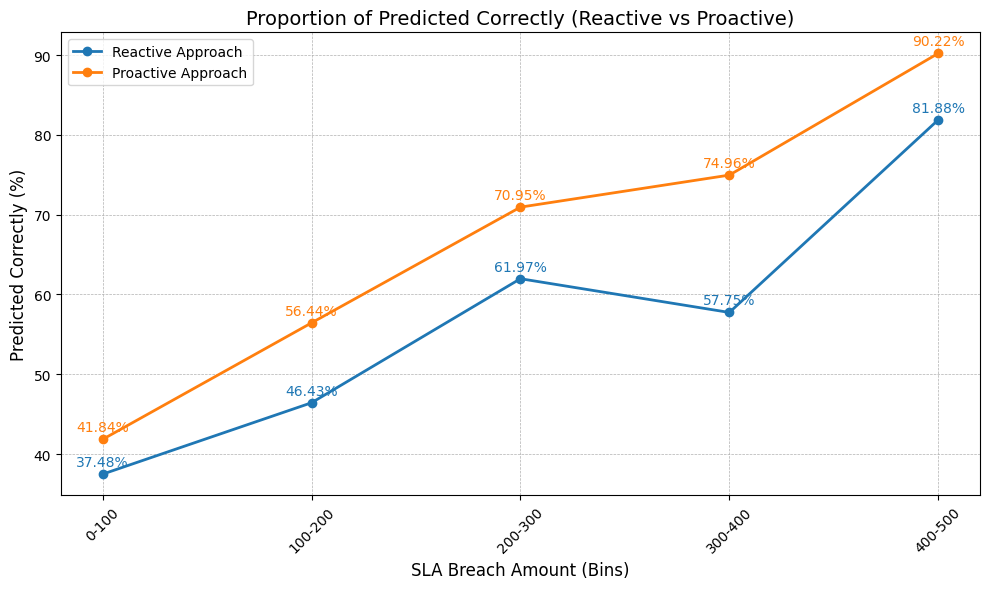

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define SLA threshold and bin size
SLA_THRESHOLD = 200
BIN_SIZE = 100
MAX_BIN = 500  # Maximum SLA range

def calculate_sla_vs_predictiontime_with_bins(df, true_data, approach_name="Approach"):
    """
    Calculate the proportion of correctly predicted vs missed SLA breaches for each bin.
    """
    
    def compute_sla_difference(true_values):
        sla_diff = np.clip(true_values - SLA_THRESHOLD, 0, None)
        return sla_diff[sla_diff > 0]

    def bin_sla_difference(sla_difference):
        bins = np.digitize(sla_difference, np.arange(0, MAX_BIN + BIN_SIZE, BIN_SIZE)) - 1
        return bins

    migrations_predicted_correctly = df[(df['migration'] == True) & (df['future_incidents'] > 0)]
    avoided_true_values = true_data[migrations_predicted_correctly.index]
    avoided_sla_difference = compute_sla_difference(avoided_true_values)
    
    migrations_missed = df[(df['migration'] == False) & (df['future_incidents'] > 0)]
    missed_true_values = true_data[migrations_missed.index]
    missed_sla_difference = compute_sla_difference(missed_true_values)

    avoided_bins = bin_sla_difference(avoided_sla_difference)
    missed_bins = bin_sla_difference(missed_sla_difference)

    bin_ranges = [f"{i*BIN_SIZE}-{(i+1)*BIN_SIZE}" for i in range(int(MAX_BIN/BIN_SIZE))]

    avoided_bin_counts = np.bincount(avoided_bins, minlength=len(bin_ranges))
    missed_bin_counts = np.bincount(missed_bins, minlength=len(bin_ranges))

    total_counts = avoided_bin_counts + missed_bin_counts
    avoided_proportions = np.divide(avoided_bin_counts, total_counts, where=total_counts != 0) * 100

    return bin_ranges, avoided_proportions

def plot_proportion_predicted_correctly(reactive_df, proactive_df, true_data):
    """
    Plot the proportion of predicted correctly (Reactive vs Proactive) for each bin.
    """
    bin_ranges_reactive, reactive_proportions = calculate_sla_vs_predictiontime_with_bins(reactive_df, true_data)
    bin_ranges_proactive, proactive_proportions = calculate_sla_vs_predictiontime_with_bins(proactive_df, true_data)

    plt.figure(figsize=(10, 6))
    
    # Plot for Reactive Approach
    plt.plot(bin_ranges_reactive, reactive_proportions, marker='o', color='#1f77b4', label="Reactive Approach", linestyle='-', linewidth=2)
    for i, (x, y) in enumerate(zip(bin_ranges_reactive, reactive_proportions)):
        plt.text(i, y + 1, f'{y:.2f}%', color='#1f77b4', fontsize=10, ha='center')

    # Plot for Proactive Approach
    plt.plot(bin_ranges_proactive, proactive_proportions, marker='o', color='#ff7f0e', label="Proactive Approach", linestyle='-', linewidth=2)
    for i, (x, y) in enumerate(zip(bin_ranges_proactive, proactive_proportions)):
        plt.text(i, y + 1, f'{y:.2f}%', color='#ff7f0e', fontsize=10, ha='center')
    
    # Add grid, labels, and title with a similar color scheme
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title("Proportion of Predicted Correctly (Reactive vs Proactive)", fontsize=14)
    plt.xlabel("SLA Breach Amount (Bins)", fontsize=12)
    plt.ylabel("Predicted Correctly (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

# Example usage for reactive and proactive approaches
plot_proportion_predicted_correctly(reactive_df, proactive_df, trues)


In [ ]:
96.19-81.64,83.66-63.4

(14.549999999999997, 20.259999999999998)

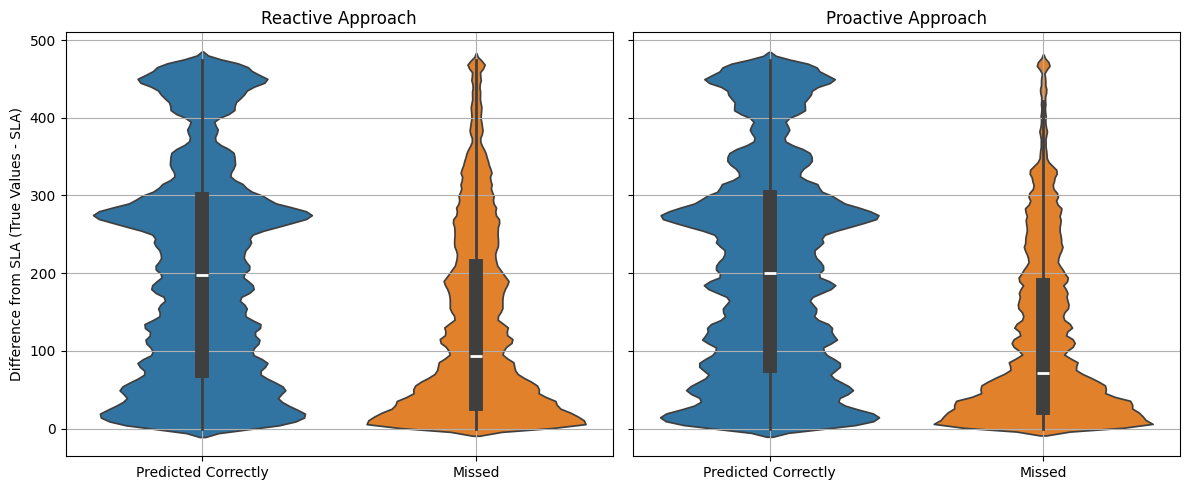

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define SLA threshold
SLA_THRESHOLD = 0.200

def plot_sla_vs_predictiontime(reactive_df, proactive_df, true_data):
    """
    Generate side-by-side plots to visualize the difference between the true values and SLA for:
    - Migrations predicted correctly (avoided SLA breaches).
    - Migrations missed (unavoidable SLA breaches).
    For both reactive and proactive approaches.
    """
    
    def compute_sla_difference(true_values):
        # Calculate how much the true values exceeded the SLA, and filter out zero differences
        sla_diff = np.clip(true_values - SLA_THRESHOLD, 0, None)  # Only consider values above SLA
        return sla_diff[sla_diff > 0]  # Exclude the zero differences

    # Function to prepare data for a given approach
    def prepare_plot_data(df, true_data):
        # 1. Migrations predicted correctly (avoided SLA breaches)
        migrations_predicted_correctly = df[(df['migration'] == True) & (df['future_incidents'] > 0)]
        avoided_true_values = true_data[migrations_predicted_correctly.index]
        avoided_sla_difference = compute_sla_difference(avoided_true_values).flatten()  # Flatten for 1D

        # 2. Migrations missed (unavoidable SLA breaches)
        migrations_missed = df[(df['migration'] == False) & (df['future_incidents'] > 0)]
        missed_true_values = true_data[migrations_missed.index]
        missed_sla_difference = compute_sla_difference(missed_true_values).flatten()  # Flatten for 1D

        # Prepare data for plotting, excluding zero differences
        plot_data = pd.DataFrame({
            'Migration Type': ['Predicted Correctly'] * len(avoided_sla_difference) + 
                              ['Missed'] * len(missed_sla_difference),
            'Difference from SLA': np.concatenate([avoided_sla_difference, missed_sla_difference])
        })

        return plot_data

    # Prepare data for both reactive and proactive approaches
    reactive_plot_data = prepare_plot_data(reactive_df, true_data)
    proactive_plot_data = prepare_plot_data(proactive_df, true_data)
   
    # Create side-by-side violin plots for Reactive and Proactive approaches, with wider boxplot inside
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    sns.violinplot(data=reactive_plot_data, x='Migration Type', y='Difference from SLA', hue='Migration Type', dodge=False, legend=False, ax=axes[0], inner_kws=dict(box_width=10, whis_width=2), bw_adjust=0.2)
    axes[0].set_title("Reactive Approach")
    axes[0].set_ylabel("Difference from SLA (True Values - SLA)")
    axes[0].set_xlabel("")
    axes[0].grid(True)

    sns.violinplot(data=proactive_plot_data, x='Migration Type', y='Difference from SLA', hue='Migration Type', dodge=False, legend=False, ax=axes[1], inner_kws=dict(box_width=10, whis_width=2), bw_adjust=0.2)
    axes[1].set_title("Proactive Approach")
    axes[1].set_ylabel("Difference from SLA (True Values - SLA)")
    axes[1].set_xlabel("")
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage with reactive and proactive data
plot_sla_vs_predictiontime(reactive_df, proactive_df, trues)


The quantitative analysis of the difference between the target variable **PredictionTime** and the **SLA** for the predicted and the missed migrations brings us understanding on where each approach is efficient on detecting the migrations. Meaning, we can see that for both Reactive and Proactive, the shape of the distribution of that difference for the Correctly Predicted samples it's practically identic, with the biggest proportion being on the cases with low differences between the true target variable and the given SLA, as those are the majority of cases in the experiment sample. However, we can see that both approaches improve the proportion of correctly predicted against missed migrations the higher this difference becomes. Both approaches are able to better flag as migrations cases in which the difference between the SLA and the actual true value is very large, which would have had a high impact for the provider. Nevertheless, the Proactive Approach seems to have a higher ability to predict the migrations the higher the differences become, this can be seen by the shape of the distribution of Missed predictions, which becomes thinner compared to the Reactive approach.   

We can quantify this improvement in Figure X, were we observe that if we split by ranges of differences, for low differences such as **0-100 and 100-200**, the **Proactive approach already performs better** than the reactive one, with **10.53% and 18.29% increase** respectively. For the middle ranges **200-300, the increase is 17.40%,**  and finally for high difference ranges such as **300-400 and 400-500** the Proactive approach improves the results by **20.26% and 14.55%** respectively. Noticeably, the biggest improvement through all the ranges comes in high ranges of 300-400 which is specially positive as missing those migrations would have a very harmful impact for the provider, as the true PredictionTime values would be extremely far from the SLA. It is also important to notice how for the highest range of difference **400-500**, the probability of the Proactive Approach to correctly flag them as a migration goes **up to 96.19%**, giving lots of confidence to this approach to tackle the cases that would impact the highest to the provider.

This superiority from the Proactive Approach results in a **reduction 43.66% of the total sum of missed SLA breaches, from 509379 ms to 287000 ms**.

In [ ]:
100-287000/509379*100

43.65688416679918